In [4]:
import pandas as pd
import numpy as np
import random
import warnings
import logging

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

%matplotlib inline


# Set random seed
rs = 42

# Ignore warnings
warnings.filterwarnings("ignore")

# Set color palette for Seaborn
colors= ['#1c76b6', '#a7dae9', '#eb6a20', '#f59d3d', '#677fa0', '#d6e4ed', '#f7e9e5']
sns.set_palette(colors)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble  import RandomForestClassifier
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score,classification_report

In [6]:
def wrangle(path, impute=None,  drop_features=[]):
    df=pd.read_csv(path)
     # Change columns titles to lower case
    df.columns=df.columns.str.lower().str.replace(' ', '-').str.replace('/', '-').to_list()
    # get numerical columns
    numerical = [col for col in df.select_dtypes(np.number).columns if col!= 'id' and col!='depression']
   
    # get categorical columns
    categorical=[col for col in df.select_dtypes('object').columns if col!='name' and col!='depression']
    # Change categorical column content to lower case
    for col in categorical:
        df[col]=df[col].str.lower()
    if impute=='conditional':
        # Impute missing values conditionally all working professional with -1 for NaN in these three fields to indicate that they are not applicable
        df.loc[df['working-professional-or-student'] == 'working professional' , ['study-satisfaction', 'academic-pressure','cgpa']]=-1
        # Impute missing values conditionally all student with - for NaN in these three fields to indicate that they are not applicable
        df.loc[df['working-professional-or-student'] == 'student' , ['work-pressure','job-satisfaction']]=-1
        # Condition for students (assuming all student entries should have 'Not Applicable' irrespective of current 'profession' value)
        df.loc[df['working-professional-or-student'] == 'student', 'profession'] = 'not applicable'
        # fill NaN with mode for remaining categorical values
        for col in categorical:
            # fill in all NaN by the mode
            mode=df[col].mode()
            df[col] = df[col].fillna(mode.iloc[0])
            # fill NaN with median for remaining numerical values
        for col in numerical:
            # fill in all NaN by the median
            median=df[col].median()
            df[col] = df[col].fillna(median)
    elif impute=='general':
        # fill NaN with mode for remaining categorical values
        for col in categorical:
            # fill in all NaN by the mode
            mode=df[col].mode()
            df[col] = df[col].fillna(mode.iloc[0])
        # fill NaN with median for remaining numerical values
        for col in numerical:
            # fill in all NaN by the median
            median=df[col].median()
            df[col] = df[col].fillna(median)
    else:
        logging.warning("No imputation performed. 'impute' parameter did not match 'conditional' or 'general'.")
        
    # features
    features=numerical +categorical
    # features to be dropped
    removed_cols = drop_features
    # Remove all instances in removed_cols
    features = [x for x in features if x not in removed_cols]
    
    return df, features   

In [7]:
dv= DictVectorizer()

In [8]:
def split_data(df, features):
    df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
    # reset index 
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    # get the target values
    y_train = df_train.depression.values
    y_val = df_val.depression.values
    y_test=df_test.depression.values
    # drop target
    del df_train['depression']
    del df_val['depression']
    del df_test['depression']
    train_dict=df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    val_dict=df_val[features].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    test_dict=df_test[features].to_dict(orient='records')
    X_test = dv.transform(test_dict)
    print( df_train.shape,df_val.shape, df_test.shape)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
df, features=wrangle('data/train.csv')

In [477]:
#df.head()
train[features]

name  gender           city working-professional-or-student  \
0       aaradhya  female       ludhiana            working professional   
1          vivan    male       varanasi            working professional   
2         yuvraj    male  visakhapatnam                         student   
3         yuvraj    male         mumbai            working professional   
4           rhea  female         kanpur            working professional   
...          ...     ...            ...                             ...   
140695     vidya  female      ahmedabad            working professional   
140696      lata  female      hyderabad            working professional   
140697   aanchal  female        kolkata            working professional   
140698    prachi  female       srinagar            working professional   
140699       sai    male          patna                         student   

               profession     sleep-duration dietary-habits    degree  \
0                    chef  more than 8 hours        healthy       bhm   
1                 teacher  less than 5 hours      unhealthy       llb   
2                     NaN          5-6 hours        healthy   b.pharm   
3                 teacher  less than 5 hours       moderate       bba   
4        business analyst          5-6 hours      unhealthy       bba   
...                   ...                ...            ...       ...   
140695                NaN          5-6 hours      unhealthy  class 12   
140696     content writer          7-8 hours       moderate    b.tech   
140697  marketing manager  more than 8 hours       moderate     b.com   
140698            plumber          5-6 hours       moderate        me   
140699                NaN  less than 5 hours        healthy       bca   

       have-you-ever-had-suicidal-thoughts-? family-history-of-mental-illness  \
0                                         no                               no   
1                                        yes                               no   
2                                        yes                               no   
3                                        yes                              yes   
4                                        yes                              yes   
...                                      ...                              ...   
140695                                    no                              yes   
140696                                   yes                              yes   
140697                                    no                               no   
140698                                   yes                               no   
140699                                   yes                              yes   

            id   age  academic-pressure  work-pressure  cgpa  \
0            0  49.0                NaN            5.0   NaN   
1            1  26.0                NaN            4.0   NaN   
2            2  33.0                5.0            NaN  8.97   
3            3  22.0                NaN            5.0   NaN   
4            4  30.0                NaN            1.0   NaN   
...        ...   ...                ...            ...   ...   
140695  140695  18.0                NaN            5.0   NaN   
140696  140696  41.0                NaN            5.0   NaN   
140697  140697  24.0                NaN            3.0   NaN   
140698  140698  49.0                NaN            5.0   NaN   
140699  140699  27.0                4.0            NaN  9.24   

        study-satisfaction  job-satisfaction  work-study-hours  \
0                      NaN               2.0               1.0   
1                      NaN               3.0               7.0   
2                      2.0               NaN               3.0   
3                      NaN               1.0              10.0   
4                      NaN               1.0               9.0   
...                    ...               ...               ...   
140695                 NaN    

In [460]:
train=pd.read_csv('data/train.csv')
original=pd.read_csv('data/final_depression_dataset_1.csv')

In [464]:
# #train.head()
# train[features]

In [465]:
train.select_dtypes('object').columns

Index(['Name', 'Gender', 'City', 'Working Professional or Student',
       'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?',
       'Family History of Mental Illness'],
      dtype='object')

In [466]:
original.select_dtypes('object').columns

Index(['Name', 'Gender', 'City', 'Working Professional or Student',
       'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?',
       'Family History of Mental Illness', 'Depression'],
      dtype='object')

In [467]:
train.select_dtypes('object').columns.to_list()


['Name',
 'Gender',
 'City',
 'Working Professional or Student',
 'Profession',
 'Sleep Duration',
 'Dietary Habits',
 'Degree',
 'Have you ever had suicidal thoughts ?',
 'Family History of Mental Illness']

In [468]:
train.shape, original.shape  # training data is 140,700 rows and original is 2,556 rows

((140700, 20), (2556, 19))

In [469]:
train.Depression.value_counts(normalize=True), original.Depression.value_counts(normalize=True)  # similar distribution

(Depression
 0    0.818287
 1    0.181713
 Name: proportion, dtype: float64,
 Depression
 No     0.821987
 Yes    0.178013
 Name: proportion, dtype: float64)

### Since original data is not much, I will keep it aside and will use it if I need to improve model performance

In [470]:
train.head(5)

id      Name  Gender   Age           City Working Professional or Student  \
0   0  Aaradhya  Female  49.0       Ludhiana            Working Professional   
1   1     Vivan    Male  26.0       Varanasi            Working Professional   
2   2    Yuvraj    Male  33.0  Visakhapatnam                         Student   
3   3    Yuvraj    Male  22.0         Mumbai            Working Professional   
4   4      Rhea  Female  30.0         Kanpur            Working Professional   

         Profession  Academic Pressure  Work Pressure  CGPA  \
0              Chef                NaN            5.0   NaN   
1           Teacher                NaN            4.0   NaN   
2               NaN                5.0            NaN  8.97   
3           Teacher                NaN            5.0   NaN   
4  Business Analyst                NaN            1.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0                 NaN               2.0  More than 8 hours        Healthy   
1                 NaN               3.0  Less than 5 hours      Unhealthy   
2                 2.0               NaN          5-6 hours        Healthy   
3                 NaN               1.0  Less than 5 hours       Moderate   
4                 NaN               1.0          5-6 hours      Unhealthy   

    Degree Have you ever had suicidal thoughts ?  Work/Study Hours  \
0      BHM                                    No               1.0   
1      LLB                                   Yes               7.0   
2  B.Pharm                                   Yes               3.0   
3      BBA                                   Yes              10.0   
4      BBA                                   Yes               9.0   

   Financial Stress Family History of Mental Illness  Depression  
0               2.0                               No           0  
1               3.0                               No           1  
2               1.0                               No           1  
3               1.0                              Yes           1  
4               4.0                              Yes           0

#### Below is a brief description of each feature in the train dataset. We should identify features relevant to the student and working professional groups.¶
id: Unique identifier. A number that uniquely identifies each row.

**Name**: Name or pseudonym. Appears to be the participant's personal identifier.

**Gender**: Gender. Can have values like Male or Female.

**Age**: Age. Represents the participant's age in numerical form.

**City**: City. The name of the city where the participant resides or is associated with.

**Working Professional or Student**: Employment status. Indicates whether the participant is a Working Professional or a Student.

**Profession: Profession**. Represents the job title for working professionals, e.g., Teacher, Chef, Business Analyst.

**Academic Pressure**: Academic stress level. Indicates the level of academic-related stress experienced by students (numerical value).

**Work Pressure**: Work stress level. Indicates the level of work-related stress experienced by working professionals (numerical value).

**CGPA**: Academic performance. Represents the student's GPA (Grade Point Average).

**Study Satisfaction**: Academic satisfaction. Indicates how satisfied students are with their studies (numerical value).

**Job Satisfaction**: Job satisfaction. Indicates how satisfied working professionals are with their current job (numerical value).

**Sleep Duration**: Sleep duration. Represents the participant's average sleep duration (e.g., 5-6 hours, Less than 5 hours).

Dietary Habits: Dietary habits. Describes the participant's dietary patterns (e.g., Healthy, Moderate, Unhealthy).

**Degree: Degree**. Indicates the degree obtained or pursued by the participant (e.g., BBA, B.Pharm, LLB).

**Have you ever had suicidal thoughts ?**: Suicidal thoughts. Indicates whether the participant has ever experienced suicidal thoughts (Yes, No).

**Work/Study Hours**: Work or study hours. The number of hours the participant spends working or studying daily (numerical value).

**Financial Stress**: Financial stress level. Indicates the level of stress participants feel due to financial issues (numerical value).

**Family History of Mental Illness**: Family history of mental illness. Indicates whether the participant's family has a history of mental illness (Yes, No).

**Depression**: Depression status. Indicates whether the participant is experiencing depression (1 = Yes, 0 = No).

In [471]:
# change all columns to lower case and replace space by a dash
train.columns=train.columns.str.lower().str.replace(' ', '-').str.replace('/', '-').to_list()
numerical=train.select_dtypes(exclude='object').columns.to_list()  # 10 but only 8 remains after dropping id and target
categorical=train.select_dtypes(include='object').columns.to_list() # 10 # Name will be dropped
#Change categorical column content to lower case
for col in categorical:
    train[col]=train[col].str.lower()

features=categorical + numerical

In [472]:
print(len(numerical), len(categorical))  # ten cols from each)
numerical, categorical  # ten cols from each

10 10


(['id',
  'age',
  'academic-pressure',
  'work-pressure',
  'cgpa',
  'study-satisfaction',
  'job-satisfaction',
  'work-study-hours',
  'financial-stress',
  'depression'],
 ['name',
  'gender',
  'city',
  'working-professional-or-student',
  'profession',
  'sleep-duration',
  'dietary-habits',
  'degree',
  'have-you-ever-had-suicidal-thoughts-?',
  'family-history-of-mental-illness'])

In [484]:
train.profession.unique()

array(['chef', 'teacher', nan, 'business analyst', 'finanancial analyst',
       'chemist', 'electrician', 'software engineer', 'data scientist',
       'plumber', 'marketing manager', 'accountant', 'entrepreneur',
       'hr manager', 'ux/ui designer', 'content writer',
       'educational consultant', 'civil engineer', 'manager',
       'pharmacist', 'financial analyst', 'architect',
       'mechanical engineer', 'customer support', 'consultant', 'judge',
       'researcher', 'pilot', 'graphic designer', 'travel consultant',
       'digital marketer', 'lawyer', 'research analyst',
       'sales executive', 'doctor', 'unemployed', 'investment banker',
       'family consultant', 'b.com', 'be', 'student', 'yogesh', 'dev',
       'mba', 'llm', 'bca', 'academic', 'profession', 'familyvirar',
       'city manager', 'bba', 'medical doctor', 'working professional',
       'mbbs', 'patna', 'unveil', 'b.ed', 'nagpur', 'moderate', 'm.ed',
       'analyst', 'pranav', 'visakhapatnam', 'phd', 'yu

In [481]:

for col in train.drop(columns=['id','name','depression'], axis=1).columns:
    print(col)
    print(train[col].unique())

gender
['female' 'male']
age
[49. 26. 33. 22. 30. 59. 47. 38. 24. 42. 55. 51. 39. 29. 50. 23. 56. 45.
 37. 46. 31. 19. 28. 25. 41. 60. 18. 36. 21. 58. 44. 43. 40. 35. 54. 27.
 52. 48. 57. 53. 34. 20. 32.]
city
['ludhiana' 'varanasi' 'visakhapatnam' 'mumbai' 'kanpur' 'ahmedabad'
 'thane' 'nashik' 'bangalore' 'patna' 'rajkot' 'jaipur' 'pune' 'lucknow'
 'meerut' 'agra' 'surat' 'faridabad' 'hyderabad' 'srinagar' 'ghaziabad'
 'kolkata' 'chennai' 'kalyan' 'nagpur' 'vadodara' 'vasai-virar' 'delhi'
 'bhopal' 'indore' 'ishanabad' 'vidhi' 'ayush' 'gurgaon' 'krishna'
 'aishwarya' 'keshav' 'harsha' 'nalini' 'aditya' 'malyansh' 'raghavendra'
 'saanvi' 'm.tech' 'bhavna' 'less delhi' 'nandini' 'm.com' 'plata'
 'atharv' 'pratyush' 'city' '3.0' 'less than 5 kalyan' 'mca' 'mira'
 'moreadhyay' 'morena' 'ishkarsh' 'kashk' 'mihir' 'vidya' 'tolkata' 'anvi'
 'krinda' 'ayansh' 'shrey' 'ivaan' 'vaanya' 'gaurav' 'harsh' 'reyansh'
 'kashish' 'kibara' 'vaishnavi' 'chhavi' 'parth' 'mahi' 'tushar' 'msc'
 'no' 'rash

### Exploratory Data Analysis

#### Missing Values

In [19]:
# check for duplicates
train.duplicated().sum()

np.int64(0)

In [20]:
train.isnull().sum()

id                                            0
name                                          0
gender                                        0
age                                           0
city                                          0
working-professional-or-student               0
profession                                36630
academic-pressure                        112803
work-pressure                             27918
cgpa                                     112802
study-satisfaction                       112803
job-satisfaction                          27910
sleep-duration                                0
dietary-habits                                4
degree                                        2
have-you-ever-had-suicidal-thoughts-?         0
work-study-hours                              0
financial-stress                              4
family-history-of-mental-illness              0
depression                                    0
dtype: int64

In [21]:
# get a list of columns that have missing values
missing_values_columns=train.isnull().sum().sort_values(ascending=False)[train.isnull().sum().sort_values(ascending=False)!=0].index.to_list()

missing_values_columns

['study-satisfaction',
 'academic-pressure',
 'cgpa',
 'profession',
 'work-pressure',
 'job-satisfaction',
 'financial-stress',
 'dietary-habits',
 'degree']

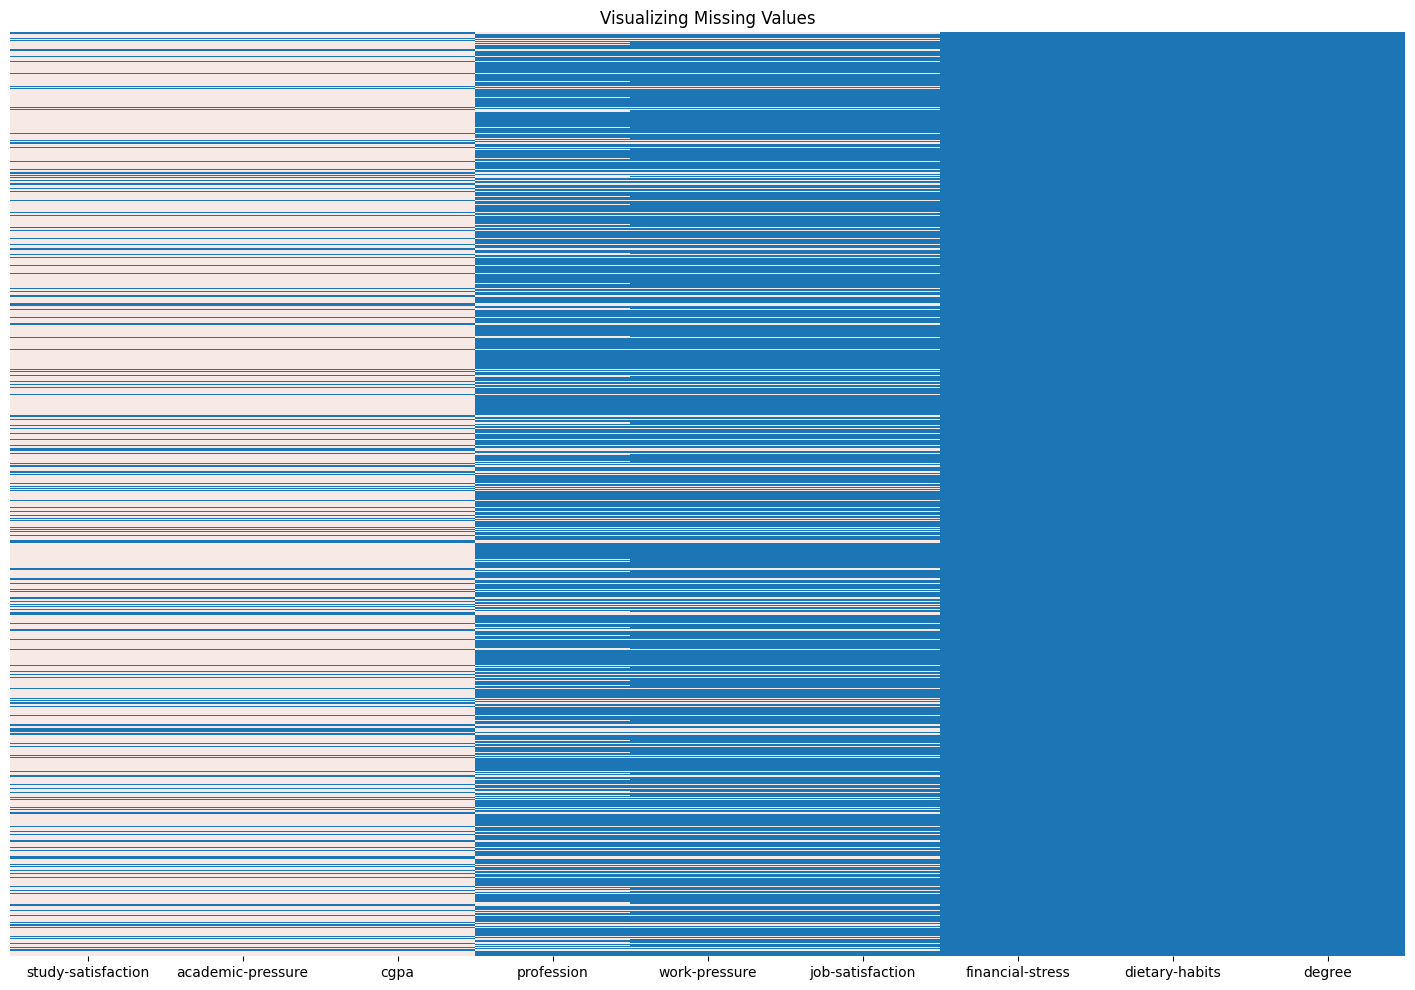

In [22]:
plt.figure(figsize=(18,12))
plt.title("Visualizing Missing Values")
sns.heatmap(train[missing_values_columns].isnull(), cbar=False, cmap=sns.color_palette(colors), yticklabels=False);

It is clear that there is a divide between students and workers.  The reason why study satisfaction, academic pressure and cgpa are NaN is because they are workers.  
Equally the reason why profession, work pressure and job satisfaction is empty is because they are students.

In [23]:
train['working-professional-or-student'].value_counts()

working-professional-or-student
working professional    112799
student                  27901
Name: count, dtype: int64

In [24]:
train[train['working-professional-or-student'] == 'working professional']['profession'].isnull().sum()

np.int64(8763)

In [25]:
# percentage of missing values
train[missing_values_columns].isnull().sum()/train.shape[0]

study-satisfaction    0.801727
academic-pressure     0.801727
cgpa                  0.801720
profession            0.260341
work-pressure         0.198422
job-satisfaction      0.198365
financial-stress      0.000028
dietary-habits        0.000028
degree                0.000014
dtype: float64

### Compare missing values between students and working professionals

In [26]:
train['working-professional-or-student'].value_counts(normalize=False)  # only 20% are students

working-professional-or-student
working professional    112799
student                  27901
Name: count, dtype: int64

In [27]:
train[
    train['working-professional-or-student']=='working professional'
    ].isnull().sum()[train[train['working-professional-or-student'
    ]=='working professional'
    ].isnull().sum()!=0].sort_values(ascending=False)  # top columns with NaN for working professionals

academic-pressure     112794
study-satisfaction    112793
cgpa                  112793
profession              8763
work-pressure             20
job-satisfaction          17
dietary-habits             2
degree                     2
financial-stress           1
dtype: int64

In [28]:
train[
    train['working-professional-or-student']=='student'
    ].isnull().sum()[train[train['working-professional-or-student'
    ]=='student'
    ].isnull().sum()!=0].sort_values(ascending=False)  # top NaN columns with students. 34 professions are filled in for students while 27867 are NaN. Some students are working

work-pressure         27898
job-satisfaction      27893
profession            27867
study-satisfaction       10
cgpa                      9
academic-pressure         9
financial-stress          3
dietary-habits            2
dtype: int64

In [29]:
train[['profession','job-satisfaction']
][train['profession'].isnull()][train['working-professional-or-student']=='working professional'] # show that for professional NaN values means it is unknown rather than unemployed

profession  job-satisfaction
29            NaN               5.0
36            NaN               4.0
43            NaN               4.0
48            NaN               5.0
50            NaN               5.0
...           ...               ...
140647        NaN               1.0
140655        NaN               3.0
140666        NaN               4.0
140667        NaN               2.0
140695        NaN               4.0

[8763 rows x 2 columns]

In [30]:
train[train['working-professional-or-student']=='student']['profession'].count()

np.int64(34)

In [31]:
train[train['working-professional-or-student']=='student']['profession'].value_counts()

profession
architect                 8
teacher                   6
student                   3
digital marketer          3
content writer            2
chef                      2
pharmacist                2
doctor                    2
civil engineer            1
ux/ui designer            1
educational consultant    1
manager                   1
lawyer                    1
entrepreneur              1
Name: count, dtype: int64

In [32]:
train[train['working-professional-or-student']=='working professional']['profession'].value_counts()

profession
teacher           24900
content writer     7812
architect          4362
consultant         4229
hr manager         4022
                  ...  
moderate              1
analyst               1
pranav                1
visakhapatnam         1
yuvraj                1
Name: count, Length: 64, dtype: int64

In [33]:
train[train['working-professional-or-student']=='working professional'].profession.value_counts(dropna=False, normalize=True) # low NaN for working professionals

profession
teacher           0.220747
NaN               0.077687
content writer    0.069256
architect         0.038671
consultant        0.037491
                    ...   
moderate          0.000009
analyst           0.000009
pranav            0.000009
visakhapatnam     0.000009
yuvraj            0.000009
Name: proportion, Length: 65, dtype: float64

In [34]:
train[
train['working-professional-or-student']=='student'
].profession.value_counts(dropna=False, normalize=True) #  Students have high NaN values in the profession field. It could mean they are not working

profession
NaN                       0.998781
architect                 0.000287
teacher                   0.000215
student                   0.000108
digital marketer          0.000108
content writer            0.000072
chef                      0.000072
pharmacist                0.000072
doctor                    0.000072
civil engineer            0.000036
ux/ui designer            0.000036
educational consultant    0.000036
manager                   0.000036
lawyer                    0.000036
entrepreneur              0.000036
Name: proportion, dtype: float64

In [35]:
train[
train['working-professional-or-student']=='student'
]['academic-pressure'].value_counts(dropna=False, normalize=True) #  Students have low NaN values in academic pressure

academic-pressure
3.0    0.267446
5.0    0.225655
4.0    0.184760
1.0    0.172073
2.0    0.149744
NaN    0.000323
Name: proportion, dtype: float64

In [36]:
train[
    train['working-professional-or-student']=='working professional']['academic-pressure'
].value_counts(dropna=False, normalize=True) # professional are mostly working and high NaN in academic pressure

academic-pressure
NaN    0.999956
4.0    0.000027
2.0    0.000009
3.0    0.000009
Name: proportion, dtype: float64

In [37]:
train[
train['working-professional-or-student']=='student'
]['work-pressure'].value_counts(dropna=False, normalize=True) #  Students have high NaN values in work pressure

work-pressure
NaN    0.999892
5.0    0.000072
2.0    0.000036
Name: proportion, dtype: float64

In [38]:
train[
    train['working-professional-or-student']=='working professional']['work-pressure'
].value_counts(dropna=False, normalize=True) # professional are mostly working and low NaN in work pressure

work-pressure
2.0    0.216066
4.0    0.199576
5.0    0.198885
3.0    0.194142
1.0    0.191154
NaN    0.000177
Name: proportion, dtype: float64

In [39]:
train[train['working-professional-or-student']=='working professional'].cgpa.value_counts(dropna=False, normalize=True) # 99.99% of values are null

cgpa
NaN     0.999947
8.14    0.000009
8.04    0.000009
8.11    0.000009
9.72    0.000009
5.42    0.000009
8.24    0.000009
Name: proportion, dtype: float64

In [40]:
train[train['working-professional-or-student']=='student'].cgpa.value_counts(dropna=False, normalize=True) # 99.99% of values are null
train[train['working-professional-or-student']=='student'].cgpa.isnull().sum()/train[train['working-professional-or-student']=='student'].shape[0] # very negligble missing values

np.float64(0.00032256908354539264)

In [41]:
train[
    train['working-professional-or-student']=='working professional']['financial-stress'
].value_counts(dropna=False) # professional have 1 NaN

financial-stress
2.0    26390
1.0    22090
4.0    21990
5.0    21564
3.0    20764
NaN        1
Name: count, dtype: int64

In [42]:
train[
    train['working-professional-or-student']=='student']['financial-stress'
].value_counts(dropna=False) # students have 3 NaNs

financial-stress
5.0    6715
4.0    5775
3.0    5226
1.0    5121
2.0    5061
NaN       3
Name: count, dtype: int64

## Handling Missing Values: A Structured and Tailored Approach

Upon detailed analysis, distinct patterns of missing values were identified in the dataset, correlating strongly with the participants' categories—students and working professionals. This categorization guided the data cleaning and preparation process:

### Pattern Identification:
- **Fields Not Applicable to Professionals:** 'Study Satisfaction', 'Academic Pressure', and 'CGPA' were predominantly missing for working professionals, indicating non-applicability to this group.
- **Fields Irrelevant for Students:** Conversely, 'Profession', 'Work Pressure', and 'Job Satisfaction' showed significant missingness among students, marking these fields as irrelevant for this subgroup.

### Targeted Data Imputation Strategies:
- **For Students:**
  - Entries not applicable to students, such as professional features, were imputed with "Not Applicable", accurately reflecting the data's irrelevance for this subgroup.
- **For Working Professionals:**
  - Missing data in 'Profession', where essential, was imputed with the mode value of this variable among working professionals, ensuring consistency and filling gaps with the most frequently observed category.
  
### Specific Imputation Methods Chosen:
- **Numerical Data:**
  - Numerical fields where data was not applicable (e.g., 'CGPA' for professionals) were set to `-1`, marking them distinctly as non-applicable.
  - Applicable numerical values missing among students were imputed using the median of the respective fields to maintain a balanced data distribution.
- **Categorical Data:**
  - "Not Applicable" was used for fields irrelevant to certain groups, maintaining clear differentiation.
  - For applicable categorical data among professionals, missing entries were filled using the mode, preserving characteristic consistency within the group.

This methodical approach to managing missing data ensured the dataset's robustness and representativeness, enhancing the accuracy of analyses and modeling. By recognizing the structured absence of data due to distinct participant groups and applying context-specific imputation methods, the integrity and reliability of the subsequent analytical procedures were upheld. Such rigor in the methodological approach is essential to avoid misinterpretation and ensure the validity and applicability of the findings to the respective groups within the dataset.


In [43]:
# Impute missing values conditionally all working professional with -1 for NaN in these three fields to indicate that they are not applicable
train.loc[train['working-professional-or-student'] == 'working professional' , ['study-satisfaction', 'academic-pressure','cgpa']]=-1
# Impute missing values conditionally all student with - for NaN in these three fields to indicate that they are not applicable
train.loc[train['working-professional-or-student'] == 'student' , ['work-pressure','job-satisfaction']]=-1
# Condition for students (assuming all student entries should have 'Not Applicable' irrespective of current 'profession' value)
train.loc[train['working-professional-or-student'] == 'student', 'profession'] = 'not applicable'

In [44]:
train.isnull().sum()

id                                          0
name                                        0
gender                                      0
age                                         0
city                                        0
working-professional-or-student             0
profession                               8763
academic-pressure                           9
work-pressure                              20
cgpa                                        9
study-satisfaction                         10
job-satisfaction                           17
sleep-duration                              0
dietary-habits                              4
degree                                      2
have-you-ever-had-suicidal-thoughts-?       0
work-study-hours                            0
financial-stress                            4
family-history-of-mental-illness            0
depression                                  0
dtype: int64

In [45]:
# fill NaN with mode for remaining categorical values
for col in categorical:
    # fill in all NaN by the mode
    mode=train[col].mode()
    train[col] = train[col].fillna(mode.iloc[0])
# fill NaN with median for remaining numerical values
for col in numerical:
    # fill in all NaN by the median
    median=train[col].median()
    train[col] = train[col].fillna(median)

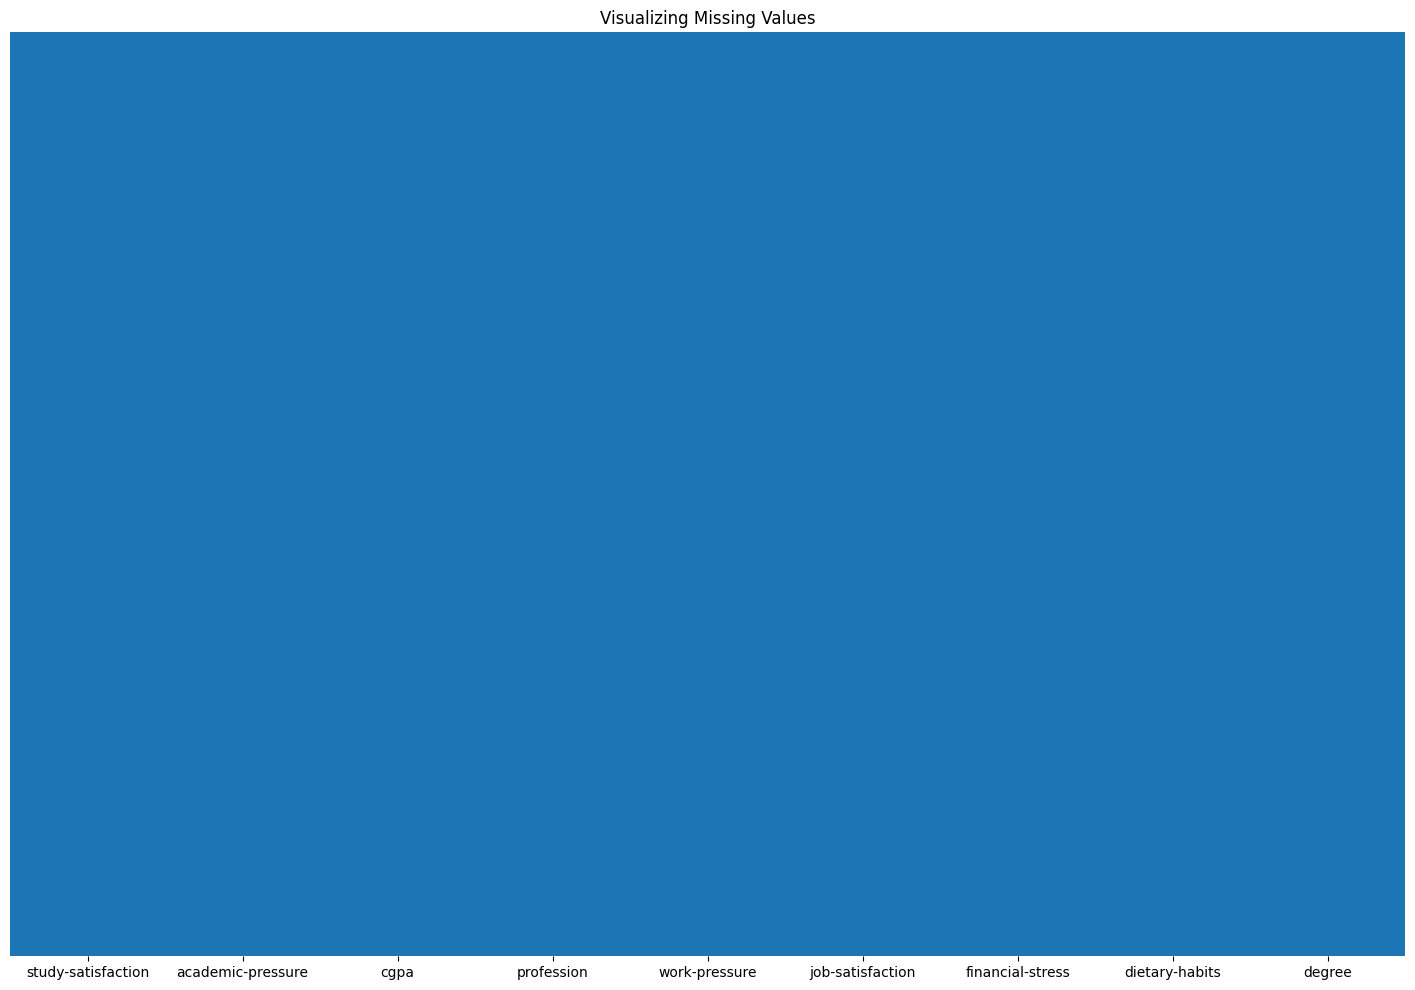

In [46]:
plt.figure(figsize=(18,12))
plt.title("Visualizing Missing Values")
sns.heatmap(train[missing_values_columns].isnull(), cbar=False, cmap=sns.color_palette(colors), yticklabels=False);

In [47]:
train.isnull().sum()

id                                       0
name                                     0
gender                                   0
age                                      0
city                                     0
working-professional-or-student          0
profession                               0
academic-pressure                        0
work-pressure                            0
cgpa                                     0
study-satisfaction                       0
job-satisfaction                         0
sleep-duration                           0
dietary-habits                           0
degree                                   0
have-you-ever-had-suicidal-thoughts-?    0
work-study-hours                         0
financial-stress                         0
family-history-of-mental-illness         0
depression                               0
dtype: int64

In [48]:
train.describe()

id            age  academic-pressure  work-pressure  \
count  140700.000000  140700.000000      140700.000000  140700.000000   
mean    70349.500000      40.388621          -0.178856       2.205828   
std     40616.735775      12.384099           1.762076       2.031324   
min         0.000000      18.000000          -1.000000      -1.000000   
25%     35174.750000      29.000000          -1.000000       1.000000   
50%     70349.500000      42.000000          -1.000000       2.000000   
75%    105524.250000      51.000000          -1.000000       4.000000   
max    140699.000000      60.000000           5.000000       5.000000   

                cgpa  study-satisfaction  job-satisfaction  work-study-hours  \
count  140700.000000       140700.000000     140700.000000     140700.000000   
mean        0.716453           -0.218003          2.186190          6.252679   
std         3.512986            1.685279          2.029434          3.853615   
min        -1.000000           -1.000000         -1.000000          0.000000   
25%        -1.000000           -1.000000          1.000000          3.000000   
50%        -1.000000           -1.000000          2.000000          6.000000   
75%        -1.000000           -1.000000          4.000000         10.000000   
max        10.000000            5.000000          5.000000         12.000000   

       financial-stress     depression  
count     140700.000000  140700.000000  
mean           2.988984       0.181713  
std            1.413613       0.385609  
min            1.000000       0.000000  
25%            2.000000       0.000000  
50%            3.000000       0.000000  
75%            4.000000       0.000000  
max            5.000000       1.000000

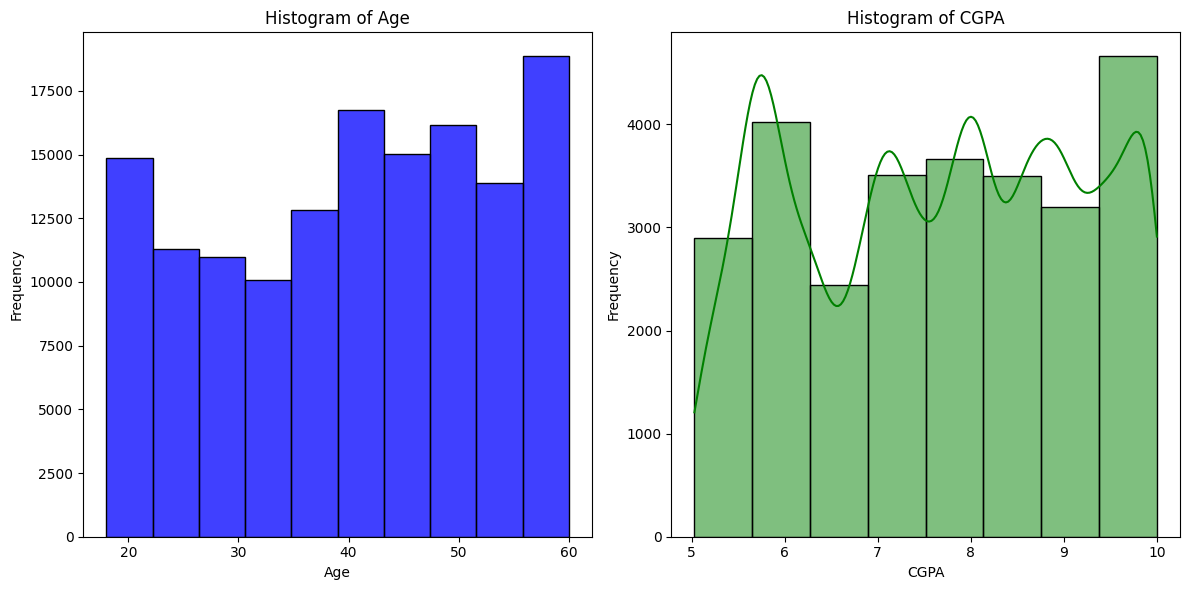

In [49]:
# Plotting histograms
plt.figure(figsize=(12, 6))  # Set the figure size

# Histogram for the 'Age' column
plt.subplot(1, 2, 1)  # 2 rows, 2 columns, 1st subplot
sns.histplot(train['age'], bins=10, kde=False, color='blue')
plt.title('Histogram of Age')  # Set title of the plot
plt.xlabel('Age')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label

# Histogram for the 'CGPA' column
filtered_data = train[train['cgpa'] != -1]  # Exclude entries with -1
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(filtered_data['cgpa'].dropna(), bins=8, kde=True, color='green')  # KDE overlay for smoothing curve
plt.title('Histogram of CGPA')  # Set title of the plot
plt.xlabel('CGPA')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

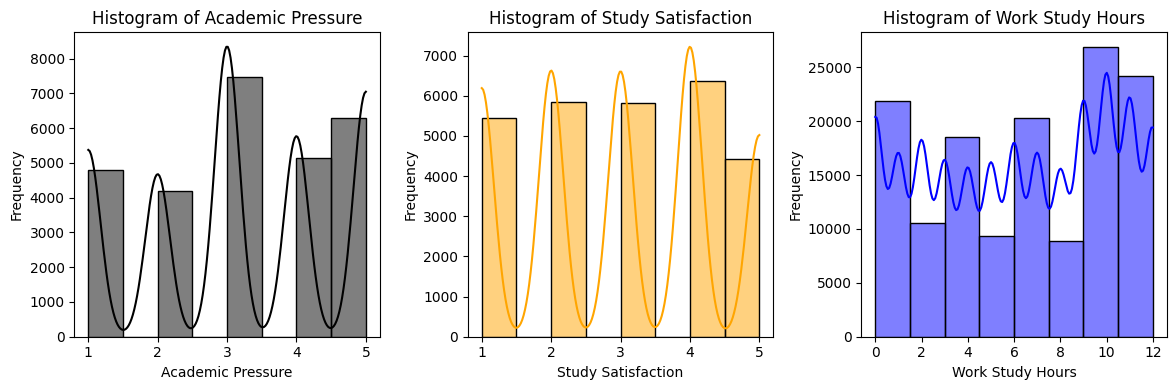

In [50]:
# Plotting histograms
plt.figure(figsize=(12, 4))  # Set the figure size
# Assuming 'CGPA' is the column with -1 representing missing data
filtered_data = train[train['academic-pressure'] != -1]  # Exclude entries with -1
# Histogram for the 'Academic Pressure' column
plt.subplot(1, 3, 1)  # 1 row, 2 columns, 2nd subplot
sns.histplot(filtered_data['academic-pressure'].dropna(), bins=8, kde=True, color='black')  # KDE overlay for smoothing curve
plt.title('Histogram of Academic Pressure')  # Set title of the plot
plt.xlabel('Academic Pressure')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label

# Histogram for the 'Study-Satisfaction' column
filtered_data = train[train['study-satisfaction'] != -1]  # Exclude entries with -1
plt.subplot(1, 3, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(filtered_data['study-satisfaction'].dropna(), bins=8, kde=True, color='orange')  # KDE overlay for smoothing curve
plt.title('Histogram of Study Satisfaction')  # Set title of the plot
plt.xlabel('Study Satisfaction')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label

# Histogram for the 'Work Study Hours' column
filtered_data = train[train['work-study-hours'] != -1]  # Exclude entries with -1
plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
sns.histplot(filtered_data['work-study-hours'].dropna(), bins=8, kde=True, color='blue')  # KDE overlay for smoothing curve
plt.title('Histogram of Work Study Hours')  # Set title of the plot
plt.xlabel('Work Study Hours')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label
plt.savefig('study_dist')
plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

In [51]:
#train[train['work-pressure']!=-1]

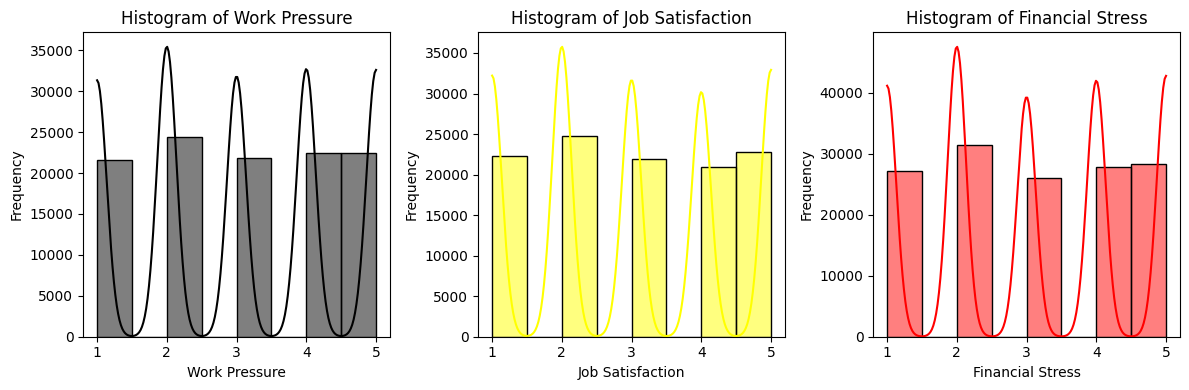

In [52]:
# Plotting histograms
plt.figure(figsize=(12, 4))  # Set the figure size
# Histogram for the 'Work Pressure' column
filtered_data = train[train['work-pressure'] != -1] 
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
sns.histplot(filtered_data['work-pressure'], bins=8, kde=True, color='black')  # KDE overlay for smoothing curve
plt.title('Histogram of Work Pressure')  # Set title of the plot
plt.xlabel('Work Pressure')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label

# Histogram for the 'Job Satisfaction' column
filtered_data = train[train['job-satisfaction'] != -1] 
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
sns.histplot(filtered_data['job-satisfaction'], bins=8, kde=True, color='yellow')  # KDE overlay for smoothing curve
plt.title('Histogram of Job Satisfaction')  # Set title of the plot
plt.xlabel('Job Satisfaction')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label

# Histogram for the 'Financial Stress' column
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
sns.histplot(train['financial-stress'], bins=8, kde=True, color='red')  # KDE overlay for smoothing curve
plt.title('Histogram of Financial Stress')  # Set title of the plot
plt.xlabel('Financial Stress')  # Set the x-label
plt.ylabel('Frequency')  # Set the y-label

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.savefig('work_dist')
plt.show()
# Histogram for the 'Work Pressure' column


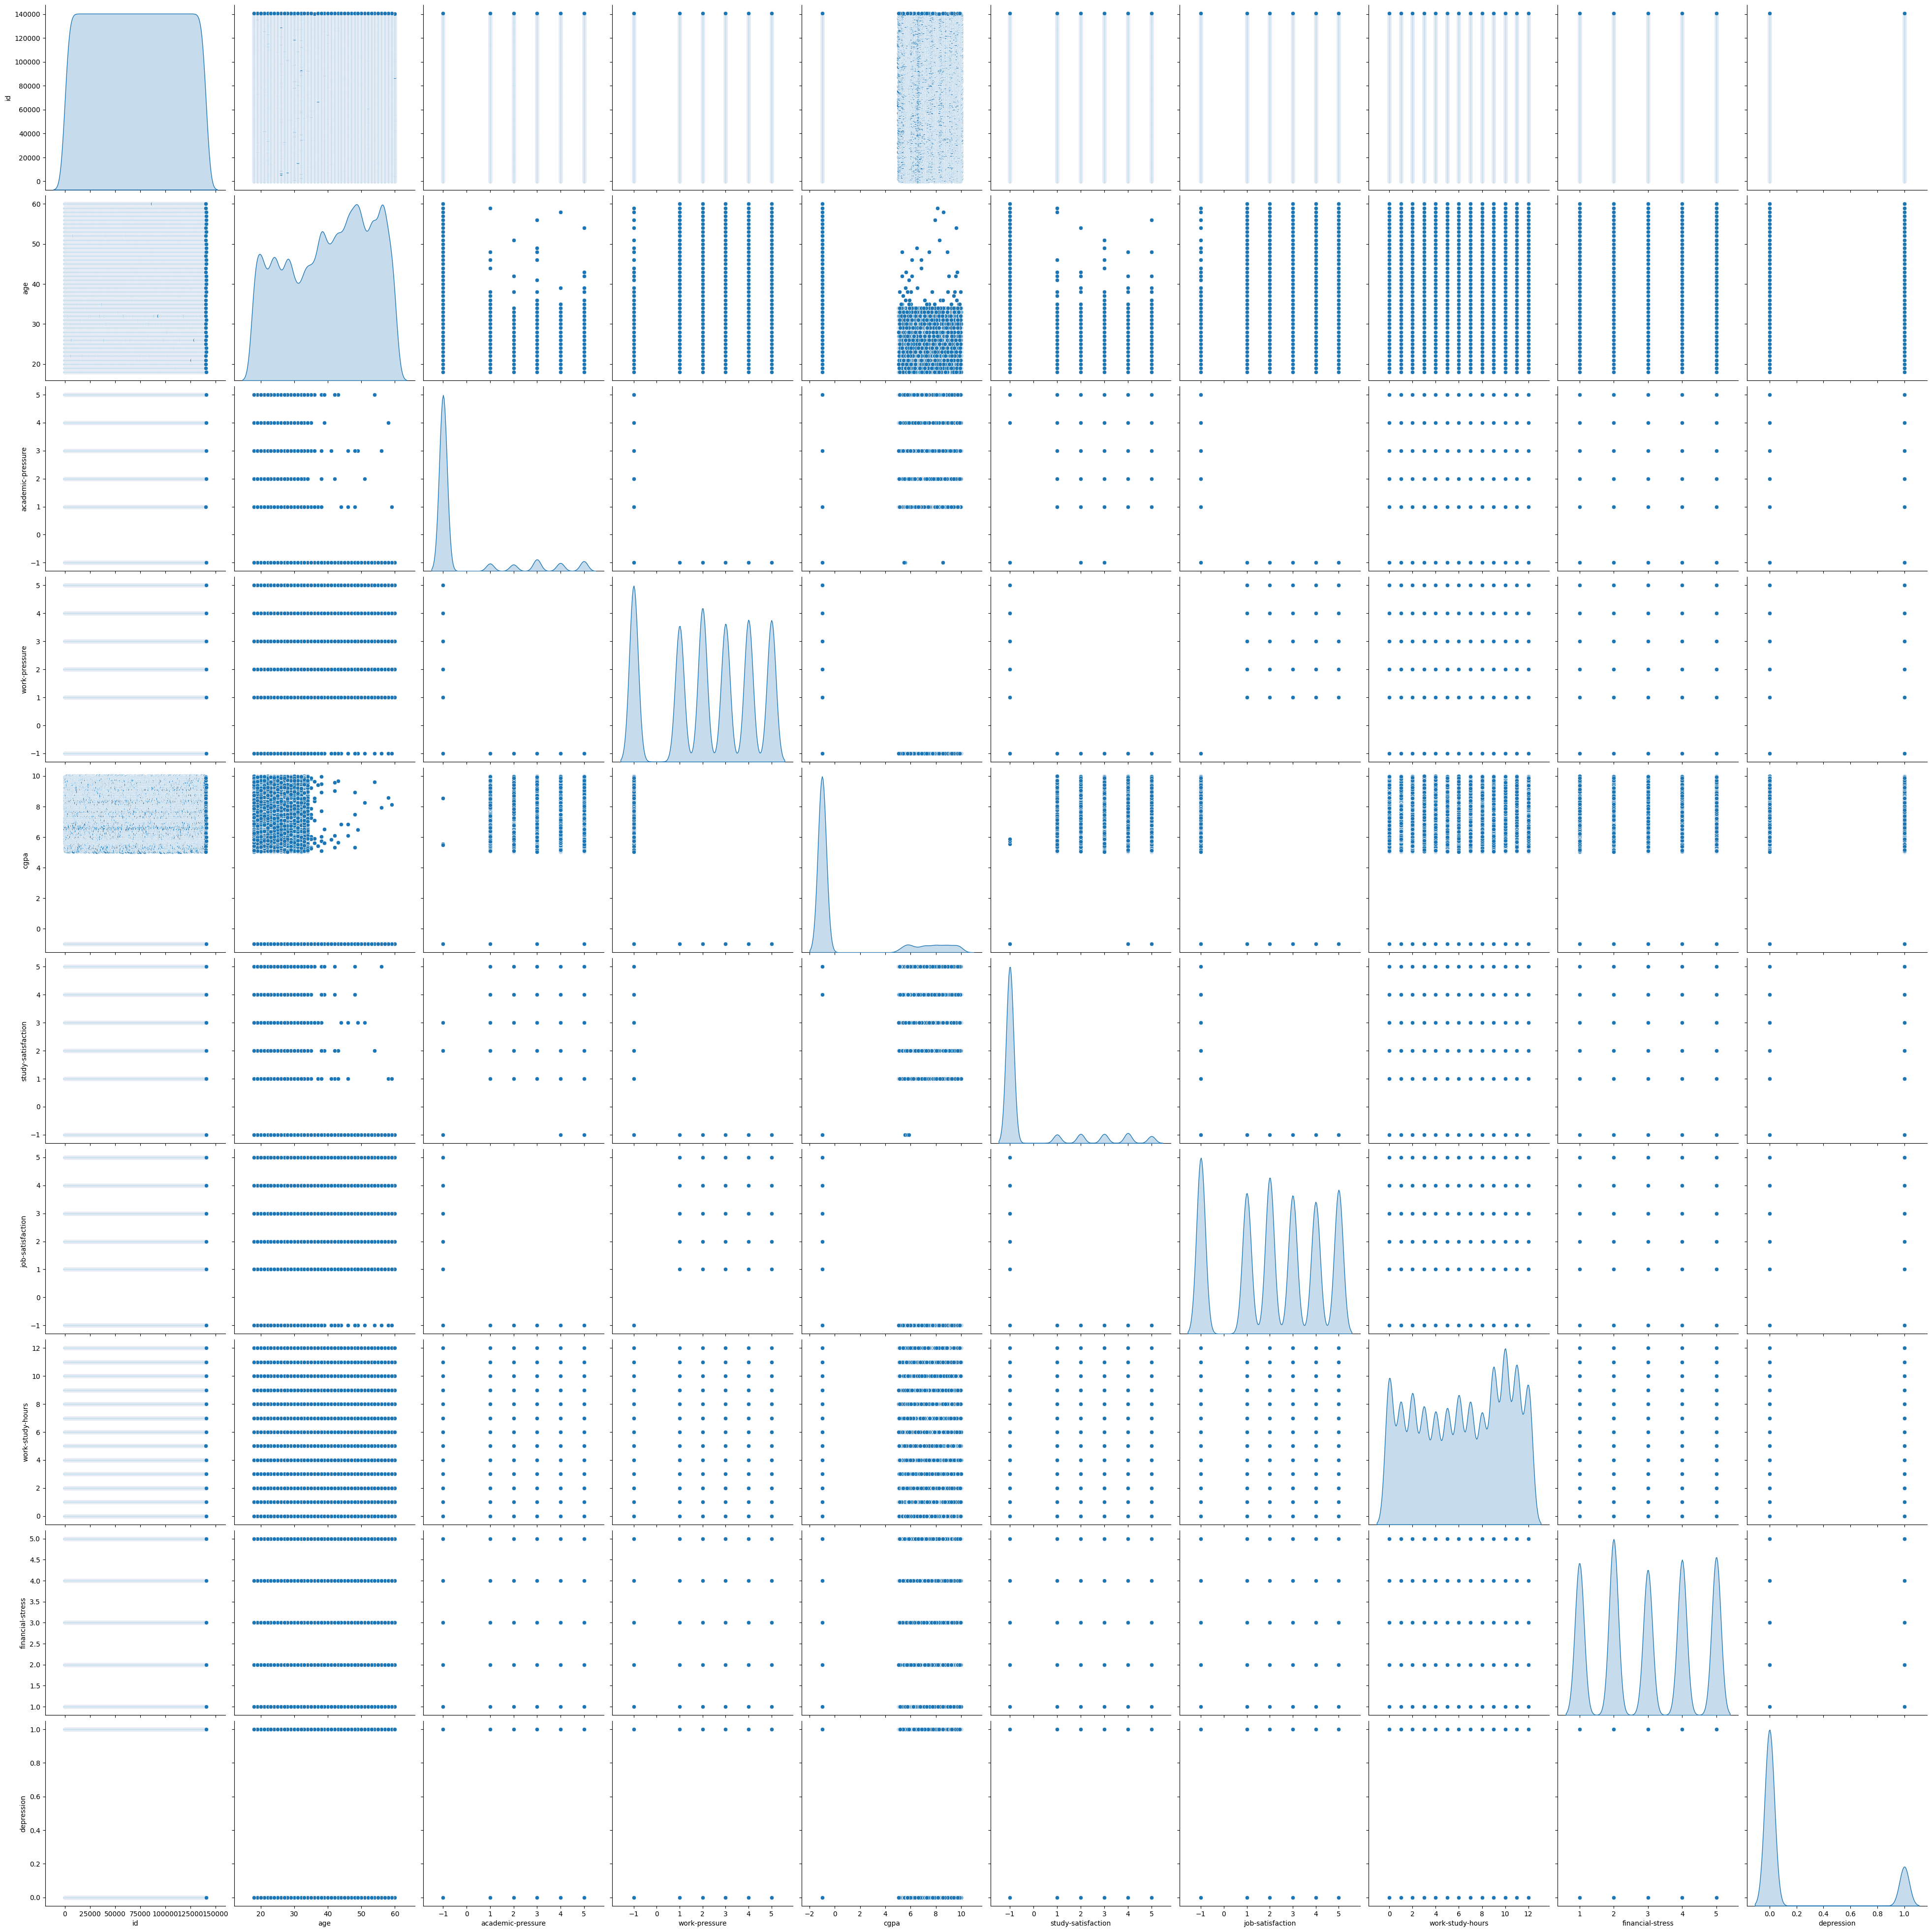

In [53]:
#checking correllation between features
sns.pairplot(train,palette='viridis', diag_kind='kde', height=4)
plt.savefig('pairplot')

In [54]:
profession_analysis = train[train['working-professional-or-student']=='working professional'].groupby('profession').agg(
    Depression_Rate=('depression', 'mean'),
    Count=('profession', 'count')
).sort_values(by='Count', ascending=False)

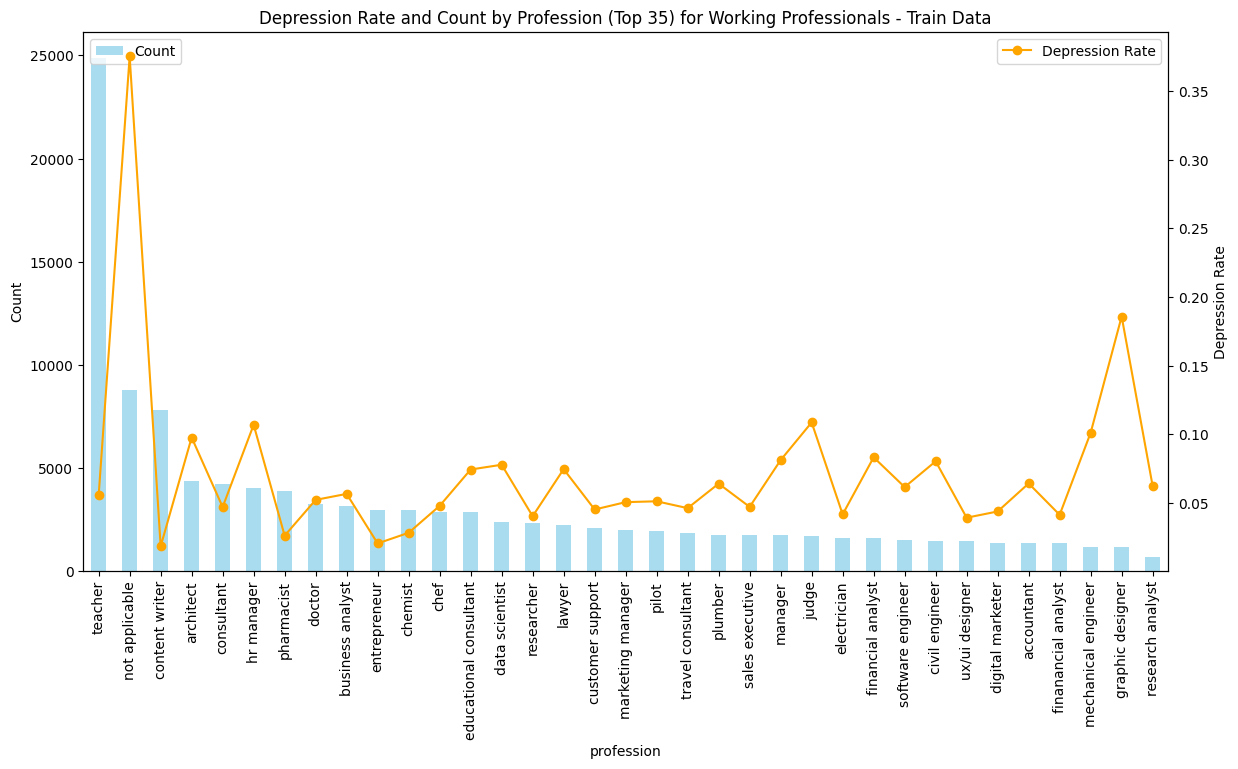

In [55]:
# Select the top 35 professions in Train data
top_35_professions = profession_analysis.head(35)

# Visualization for Train data
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for the count of records
top_35_professions['Count'].plot(
    kind='bar', color='skyblue', ax=ax1, alpha=0.7, label='Count'
)
ax1.set_ylabel('Count')
ax1.set_title('Depression Rate and Count by Profession (Top 35) for Working Professionals - Train Data')
ax1.legend(loc='upper left')

# Line plot for depression rates
ax2 = ax1.twinx()
top_35_professions['Depression_Rate'].plot(
    kind='line', color='orange', ax=ax2, marker='o', label='Depression Rate'
)
ax2.set_ylabel('Depression Rate')
ax2.legend(loc='upper right')
# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.savefig('workering-professional')
plt.show()

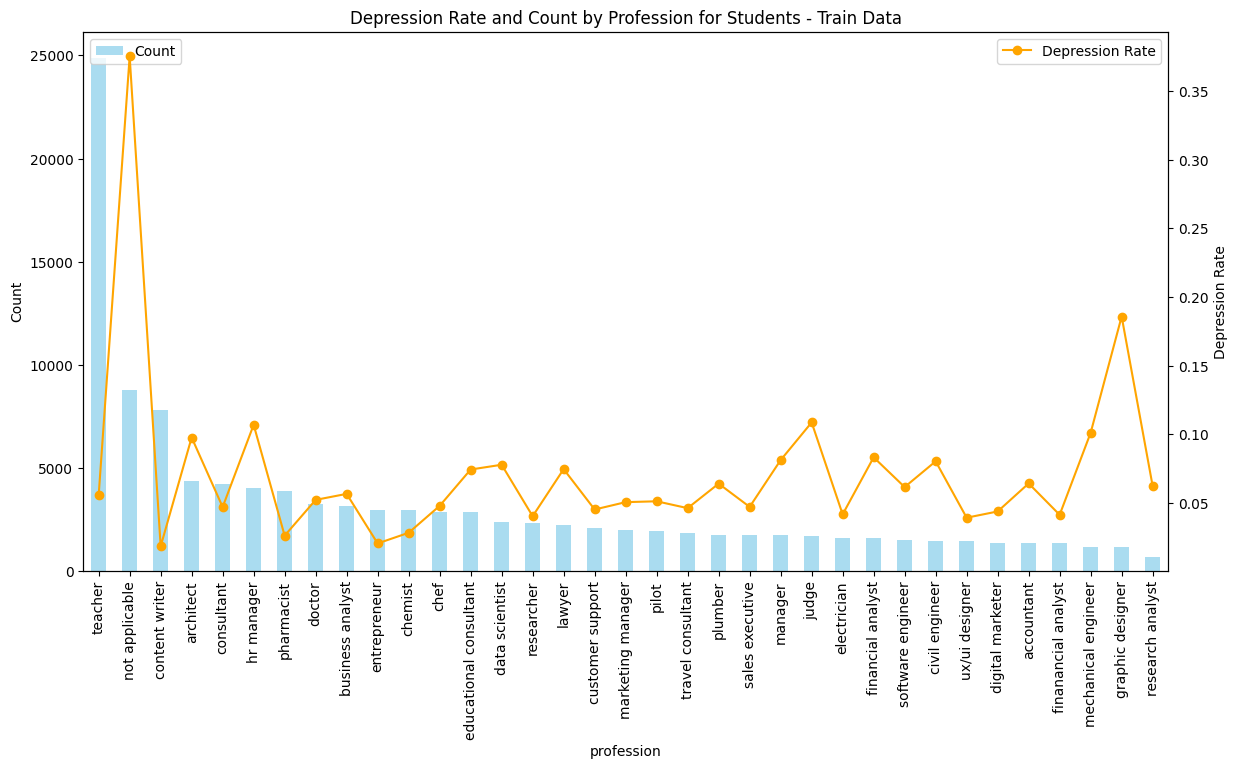

In [56]:
profession_analysis = train[train['working-professional-or-student']=='student'].groupby('profession').agg(
    Depression_Rate=('depression', 'mean'),
    Count=('profession', 'count')
).sort_values(by='Count', ascending=False)

# Select the top 35 professions in Train data
top_professions = profession_analysis.head(35)

# Visualization for Train data
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for the count of records
top_35_professions['Count'].plot(
    kind='bar', color='skyblue', ax=ax1, alpha=0.7, label='Count'
)
ax1.set_ylabel('Count')
ax1.set_title('Depression Rate and Count by Profession for Students - Train Data')
ax1.legend(loc='upper left')

# Line plot for depression rates
ax2 = ax1.twinx()
top_35_professions['Depression_Rate'].plot(
    kind='line', color='orange', ax=ax2, marker='o', label='Depression Rate'
)
ax2.set_ylabel('Depression Rate')
ax2.legend(loc='upper right')
# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.savefig('student-workers')
plt.show()



## Clean and Explore

In [57]:
print("The skewness of columns:")
print(train[numerical].skew())

The skewness of columns:
id                    0.000000
age                  -0.217977
academic-pressure     1.921388
work-pressure        -0.277192
cgpa                  1.639488
study-satisfaction    1.958661
job-satisfaction     -0.250868
work-study-hours     -0.128169
financial-stress      0.035603
depression            1.650852
dtype: float64


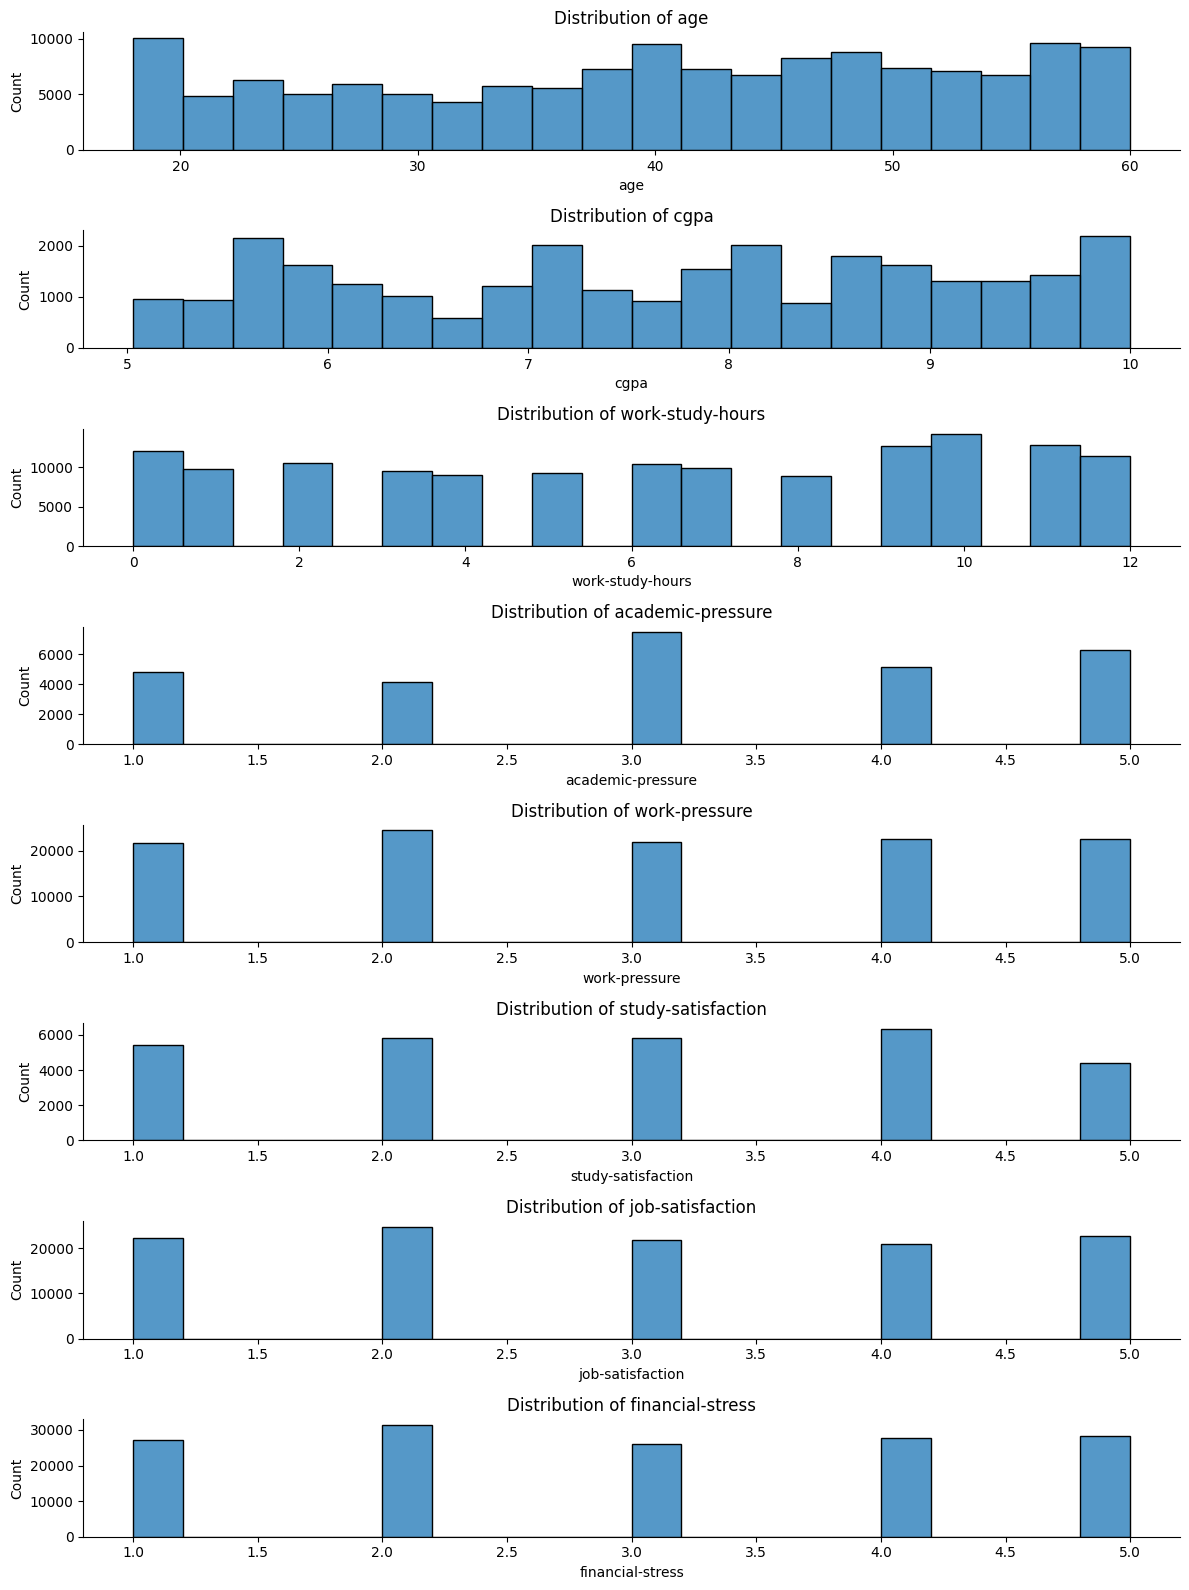

In [58]:
numerical_columns_to_plot = ["age", "cgpa", "work-study-hours", 
                             'academic-pressure', 'work-pressure', 'study-satisfaction',
                             'job-satisfaction', 'financial-stress',]

plt.figure(figsize=(12, 16)) 

for i, column in enumerate(numerical_columns_to_plot):
    
    plt.subplot(8, 1, i+1)
    sns.histplot(data=train[train[column]!=-1], x=column, kde=False, bins=20, color=colors[0])
    plt.title(f'Distribution of {column}')
    sns.despine()

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

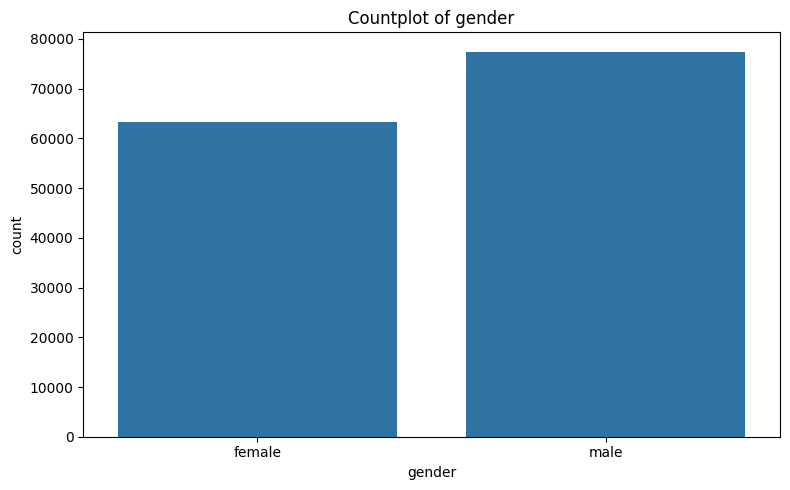

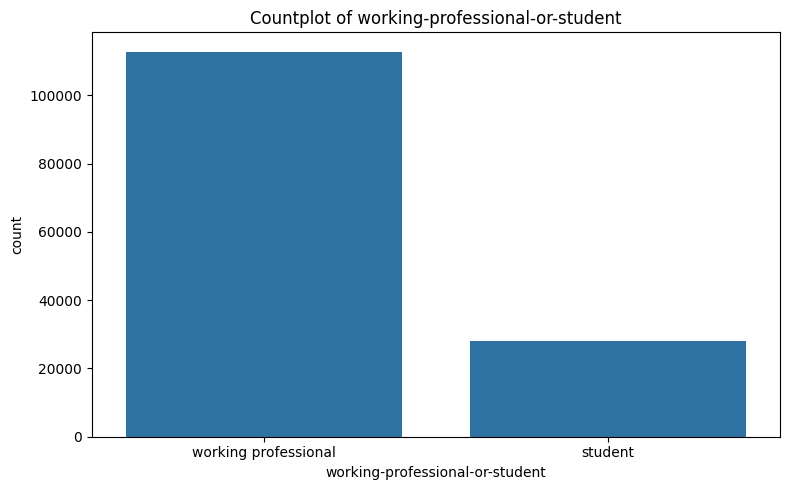

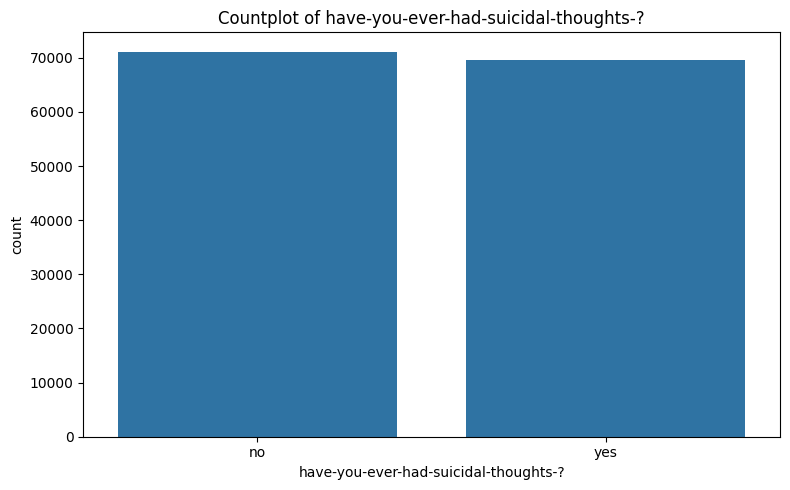

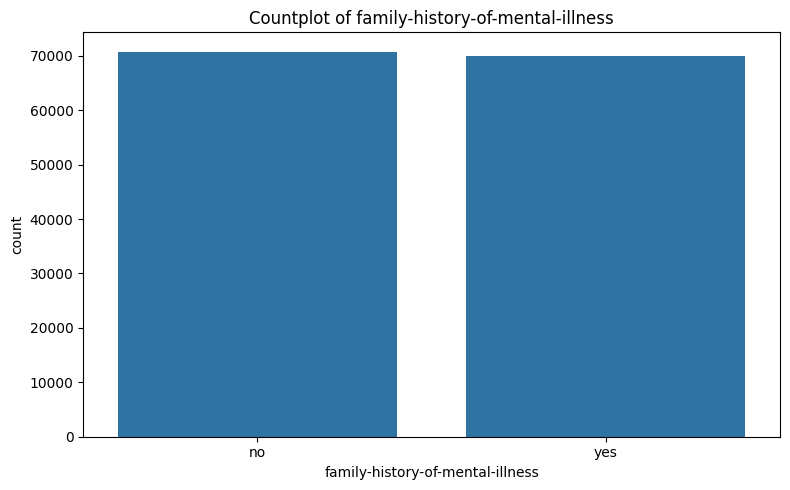

In [59]:
categorical_columns_to_plot = ['gender',

 'working-professional-or-student',
 'have-you-ever-had-suicidal-thoughts-?',
 'family-history-of-mental-illness']   # removed dietary habits, sleep duration, profession, degree and city as they have too many unique values

# Plot countplots for each categorical column
for column in categorical_columns_to_plot:
    
    plt.figure(figsize=(8, 5))
    sns.countplot(data=train, x=column)
    plt.title(f'Countplot of {column}')
    
    plt.tight_layout()
    plt.show()
    
 

### Feature Importances

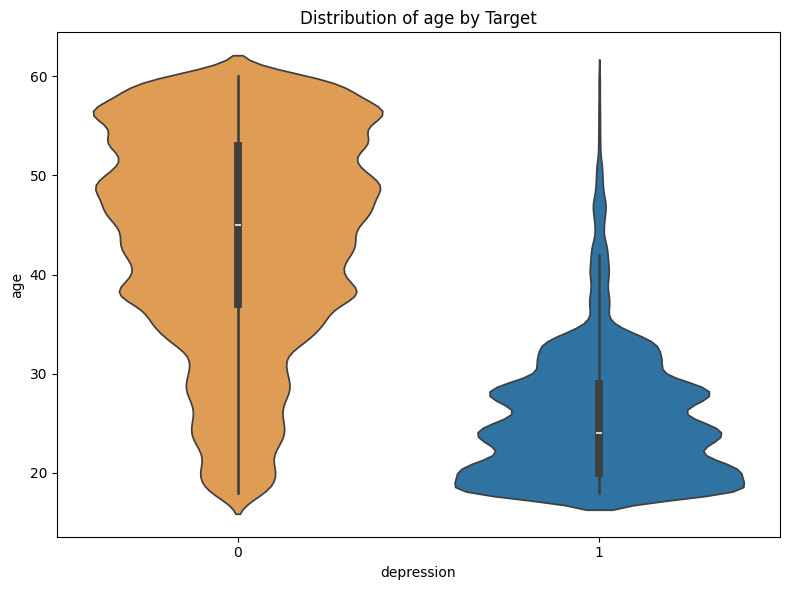

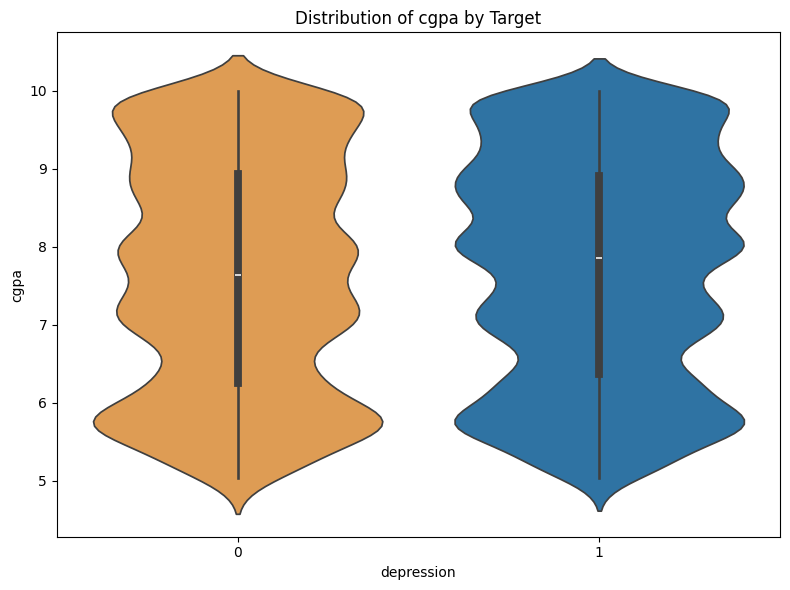

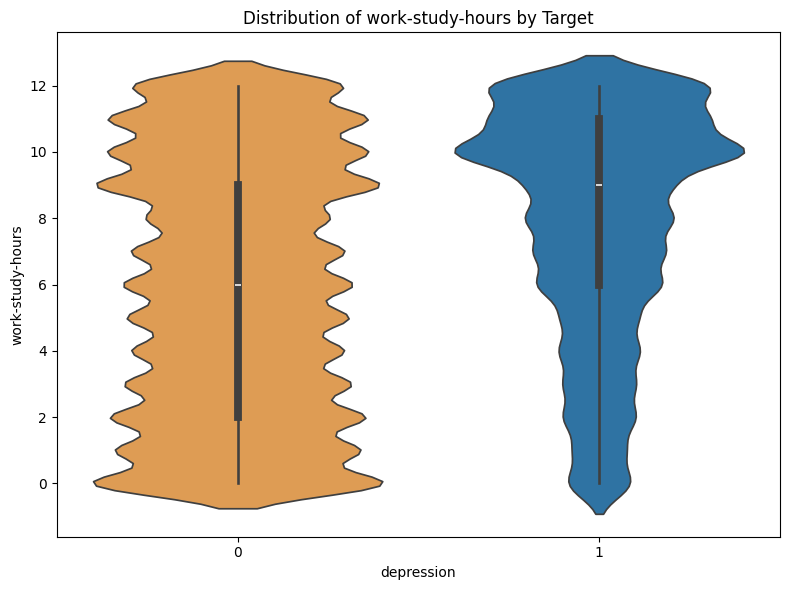

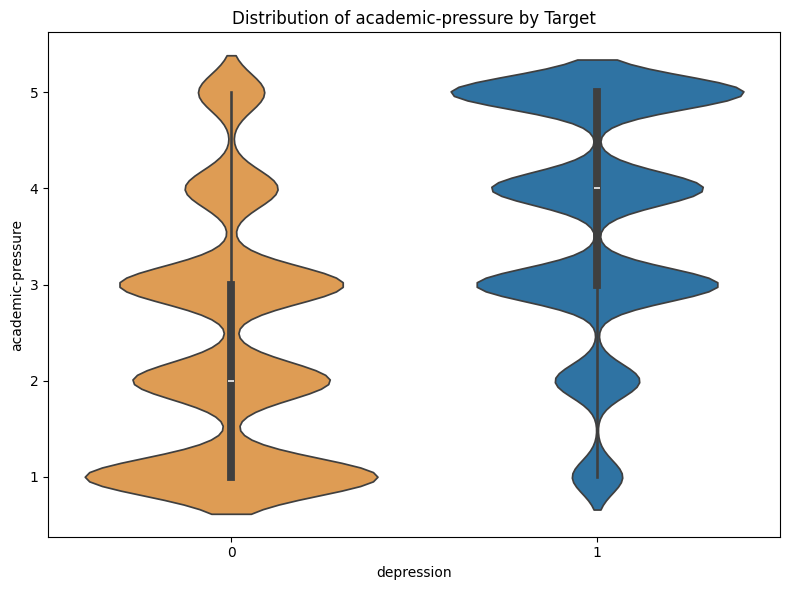

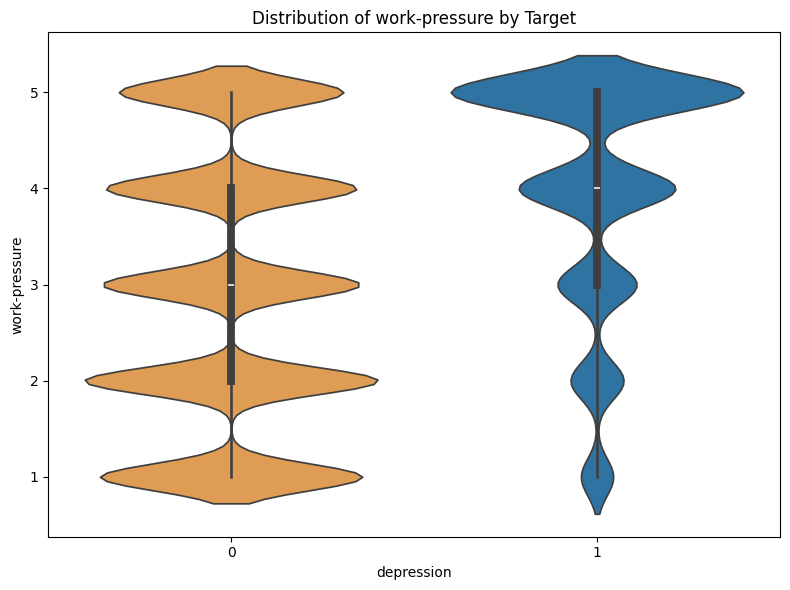

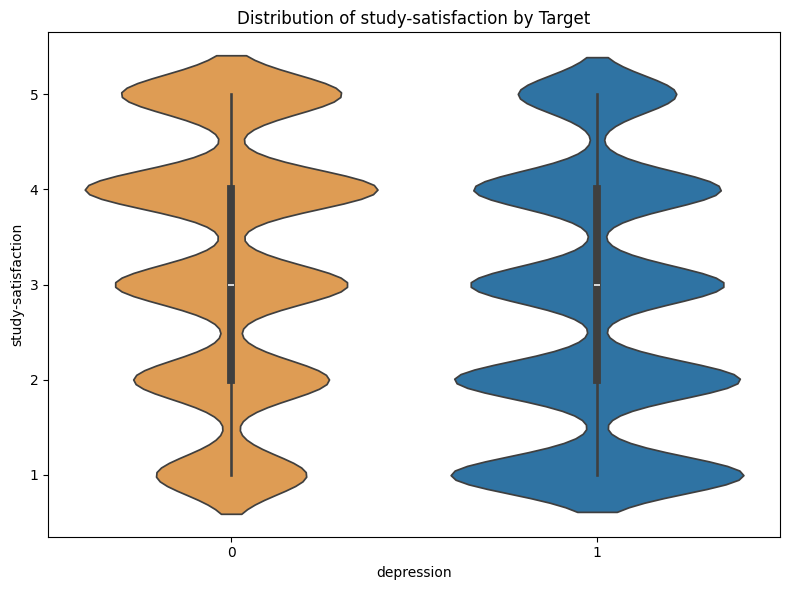

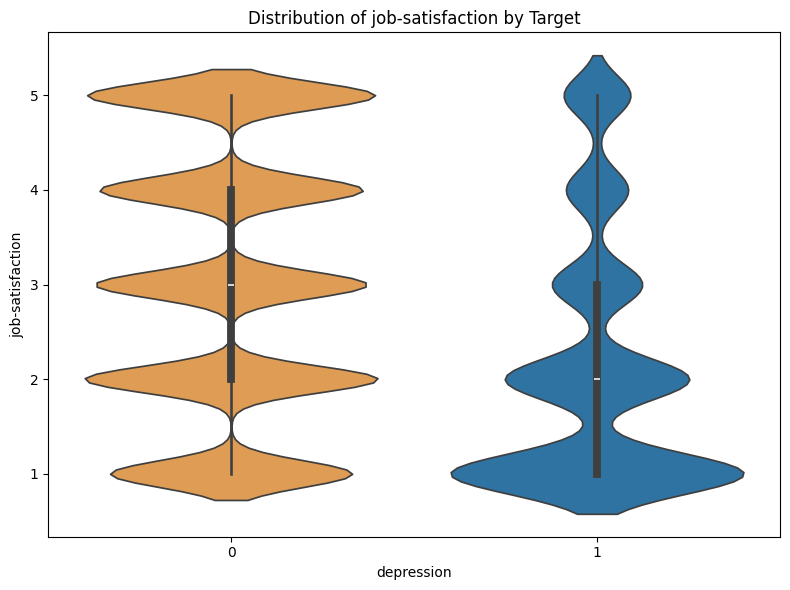

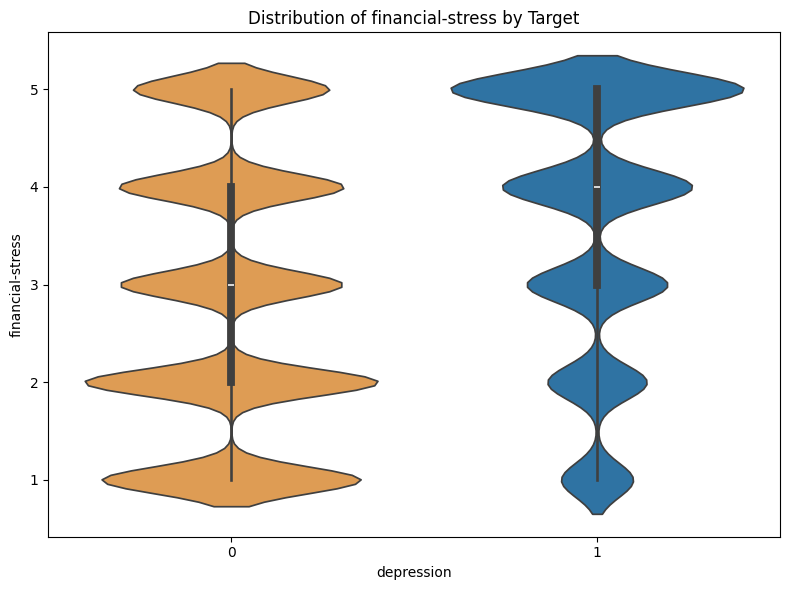

In [60]:
bi_palette = [colors[3], colors[0]]
target_column='depression'
for column in numerical_columns_to_plot:
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=train[train[column]!=-1], x=target_column, y=column, palette=bi_palette) 
    plt.title(f'Distribution of {column} by Target')

    plt.tight_layout()
    plt.savefig(column)
    plt.show()
    

In [61]:
global_mean=train.depression.mean()
global_mean

np.float64(0.18171286425017769)

In [62]:
from IPython.display import display
for col in categorical:
    df_group = train.groupby(by=col).depression.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

mean      diff      risk
name                                
18      1.000000  0.818287  5.503188
a.ed    0.000000 -0.181713  0.000000
aadhya  0.191868  0.010155  1.055885
aahana  0.207420  0.025707  1.141471
aakash  0.217252  0.035540  1.195581
...          ...       ...       ...
yuvraj  0.172603 -0.009110  0.949865
zahra   0.000000 -0.181713  0.000000
zara    0.091043 -0.090670  0.501024
zegmay  0.000000 -0.181713  0.000000
zoya    0.090517 -0.091196  0.498133

[422 rows x 3 columns]

mean      diff      risk
gender                              
female  0.178237 -0.003476  0.980872
male    0.184550  0.002837  1.015615

mean      diff      risk
city                                       
3.0            1.000000  0.818287  5.503188
aaradhya       0.000000 -0.181713  0.000000
aditya         0.000000 -0.181713  0.000000
agra           0.192357  0.010644  1.058576
ahmedabad      0.217887  0.036174  1.199073
...                 ...       ...       ...
varanasi       0.142206 -0.039507  0.782585
vasai-virar    0.197918  0.016206  1.089183
vidhi          0.000000 -0.181713  0.000000
vidya          0.000000 -0.181713  0.000000
visakhapatnam  0.159196 -0.022517  0.876087

[98 rows x 3 columns]

mean      diff      risk
working-professional-or-student                              
student                          0.585499  0.403786  3.222109
working professional             0.081836 -0.099877  0.450358

mean      diff      risk
profession                                        
academic              0.000000 -0.181713  0.000000
accountant            0.064227 -0.117486  0.353453
analyst               0.000000 -0.181713  0.000000
architect             0.097662 -0.084051  0.537450
b.com                 0.000000 -0.181713  0.000000
...                        ...       ...       ...
ux/ui designer        0.039283 -0.142430  0.216183
visakhapatnam         0.000000 -0.181713  0.000000
working professional  0.000000 -0.181713  0.000000
yogesh                0.666667  0.484954  3.668792
yuvraj                0.000000 -0.181713  0.000000

[65 rows x 3 columns]

mean      diff      risk
sleep-duration                                 
1-2 hours          0.000000 -0.181713  0.000000
1-3 hours          0.000000 -0.181713  0.000000
1-6 hours          0.000000 -0.181713  0.000000
10-11 hours        1.000000  0.818287  5.503188
10-6 hours         0.000000 -0.181713  0.000000
2-3 hours          0.200000  0.018287  1.100638
3-4 hours          0.083333 -0.098380  0.458599
3-6 hours          0.000000 -0.181713  0.000000
35-36 hours        0.000000 -0.181713  0.000000
4-5 hours          0.142857 -0.038856  0.786170
4-6 hours          0.200000  0.018287  1.100638
40-45 hours        1.000000  0.818287  5.503188
45                 0.000000 -0.181713  0.000000
45-48 hours        0.000000 -0.181713  0.000000
49 hours           0.000000 -0.181713  0.000000
5-6 hours          0.165578 -0.016135  0.911205
55-66 hours        1.000000  0.818287  5.503188
6-7 hours          0.250000  0.068287  1.375797
6-8 hours          0.000000 -0.181713  0.000000
7-8 hours          0.178339 -0.003374  0.981431
8 hours            1.000000  0.818287  5.503188
8-9 hours          0.500000  0.318287  2.751594
9-11 hours         0.000000 -0.181713  0.000000
9-5                0.000000 -0.181713  0.000000
9-5 hours          0.000000 -0.181713  0.000000
9-6 hours          0.000000 -0.181713  0.000000
indore             0.000000 -0.181713  0.000000
less than 5 hours  0.234659  0.052946  1.291370
moderate           0.000000 -0.181713  0.000000
more than 8 hours  0.138697 -0.043016  0.763276
no                 0.000000 -0.181713  0.000000
pune               0.000000 -0.181713  0.000000
sleep_duration     0.000000 -0.181713  0.000000
than 5 hours       0.000000 -0.181713  0.000000
unhealthy          0.000000 -0.181713  0.000000
work_study_hours   0.000000 -0.181713  0.000000

mean      diff      risk
dietary-habits                                 
1.0                1.000000  0.818287  5.503188
2                  0.000000 -0.181713  0.000000
3                  1.000000  0.818287  5.503188
bsc                0.000000 -0.181713  0.000000
class 12           0.000000 -0.181713  0.000000
electrician        0.000000 -0.181713  0.000000
gender             0.000000 -0.181713  0.000000
healthy            0.118035 -0.063678  0.649568
hormonal           0.000000 -0.181713  0.000000
indoor             1.000000  0.818287  5.503188
less healthy       0.000000 -0.181713  0.000000
less than healthy  0.000000 -0.181713  0.000000
m.tech             1.000000  0.818287  5.503188
male               1.000000  0.818287  5.503188
mihir              0.000000 -0.181713  0.000000
moderate           0.165664 -0.016049  0.911681
more healthy       0.000000 -0.181713  0.000000
no                 0.000000 -0.181713  0.000000
no healthy         1.000000  0.818287  5.503188
pratham            0.000000 -0.181713  0.000000
unhealthy          0.260540  0.078828  1.433803
vegas              0.000000 -0.181713  0.000000
yes                0.500000  0.318287  2.751594

mean      diff      risk
degree                                        
0                      1.0  0.818287  5.503188
20                     1.0  0.818287  5.503188
24                     1.0  0.818287  5.503188
29                     0.0 -0.181713  0.000000
5.56                   0.0 -0.181713  0.000000
...                    ...       ...       ...
ux/ui designer         0.0 -0.181713  0.000000
veda                   0.0 -0.181713  0.000000
vivaan                 0.0 -0.181713  0.000000
vrinda                 0.0 -0.181713  0.000000
working professional   0.0 -0.181713  0.000000

[115 rows x 3 columns]

mean      diff      risk
have-you-ever-had-suicidal-thoughts-?                              
no                                     0.048610 -0.133103  0.267509
yes                                    0.317832  0.136119  1.749087

mean      diff      risk
family-history-of-mental-illness                              
no                                0.175387 -0.006326  0.965185
yes                               0.188113  0.006400  1.035221

In [63]:
categorical

['name',
 'gender',
 'city',
 'working-professional-or-student',
 'profession',
 'sleep-duration',
 'dietary-habits',
 'degree',
 'have-you-ever-had-suicidal-thoughts-?',
 'family-history-of-mental-illness']

In [64]:
# drop columns that have no impact
numerical.remove('id')
categorical.remove('name')

In [65]:
from sklearn.metrics import mutual_info_score
def calculate_mi(series):
    return mutual_info_score(series, train.depression)

df_mi = train[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

df_mi

MI
profession                             0.136735
working-professional-or-student        0.112377
have-you-ever-had-suicidal-thoughts-?  0.066581
degree                                 0.038580
dietary-habits                         0.011470
sleep-duration                         0.004311
city                                   0.003941
family-history-of-mental-illness       0.000136
gender                                 0.000033

## Variance Inflation Factor (VIF):

Calculate the VIF for each variable. A VIF value greater than 10 (some sources say 5) suggests significant multicollinearity.

In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Assume 'df' initially includes the target
# dropped cgpa as it had high colinearity
X = train[numerical]  # Ensure 'X' contains only features

# Add a constant for intercept
X = add_constant(X)

# Calculate VIF for each feature plus the constant
VIF = pd.Series([variance_inflation_factor(X.values, i) 
                 for i in range(X.shape[1])], 
                index=X.columns)
print(VIF)

const                 37.487159
age                    1.774059
academic-pressure      7.594957
work-pressure          2.597502
cgpa                  11.749650
study-satisfaction     6.390262
job-satisfaction       2.520915
work-study-hours       1.039634
financial-stress       1.062055
depression             2.006159
dtype: float64


In [67]:
train.select_dtypes('object').nunique()

name                                     422
gender                                     2
city                                      98
working-professional-or-student            2
profession                                65
sleep-duration                            36
dietary-habits                            23
degree                                   115
have-you-ever-had-suicidal-thoughts-?      2
family-history-of-mental-illness           2
dtype: int64

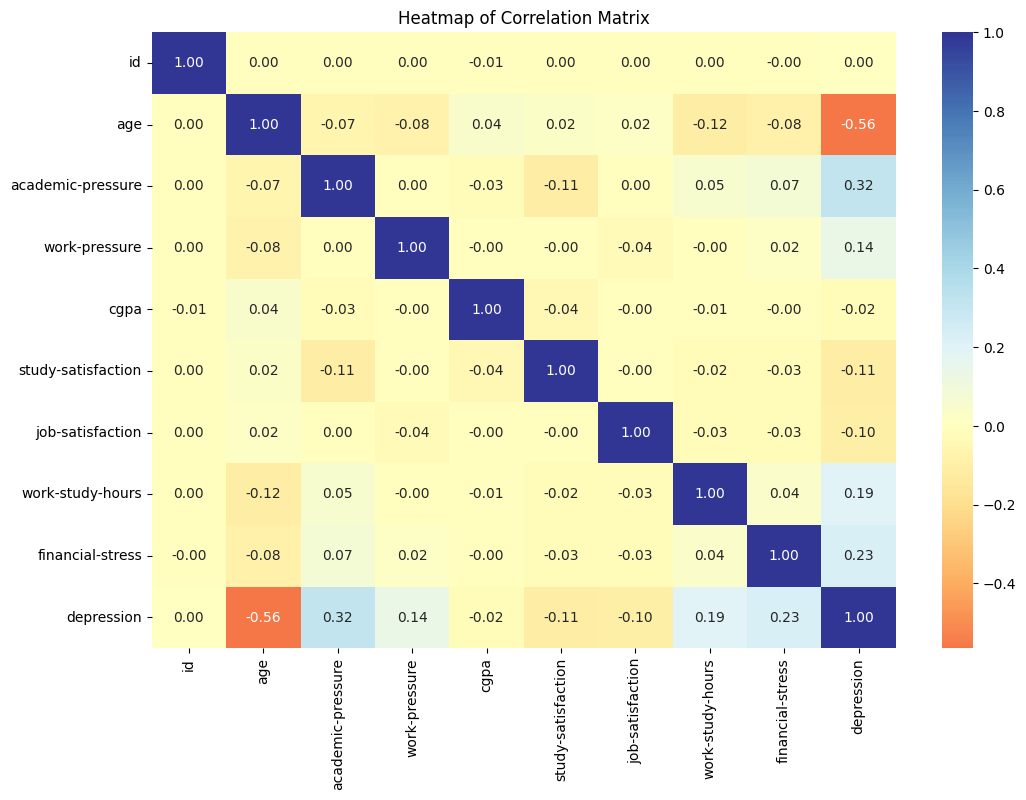

In [68]:
# Now we will use the wrangle function to process the data and change some variables
df, features =wrangle('data/train.csv', impute='general')
# Calculate the correlation matrix without imputing missing values
correlation_matrix = df.corr(numeric_only=True)

# Create a heatmap with orange and blue colors
plt.figure(figsize=(12, 8))
fig = sns.heatmap(correlation_matrix, 
                  annot=True,         # Display correlation values
                  cmap='RdYlBu',      # Color scale with shades of red, yellow, and blue
                  center=0,fmt=".2f" )


# Add title
plt.title('Heatmap of Correlation Matrix')

# Show the plot
plt.show()

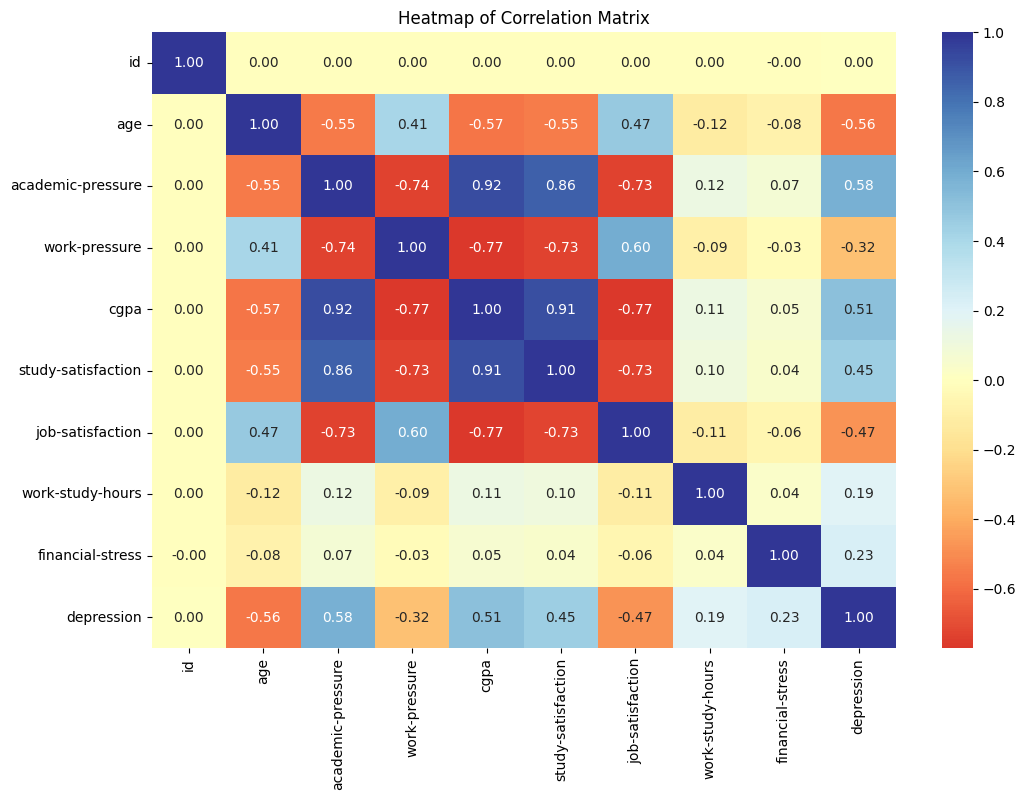

In [69]:
# Now we will use the wrangle function to process the data and change some variables
df, features =wrangle('data/train.csv', impute='conditional')
# Calculate the correlation matrix without imputing missing values
correlation_matrix = df.corr(numeric_only=True)

# Create a heatmap with orange and blue colors
plt.figure(figsize=(12, 8))
fig = sns.heatmap(correlation_matrix, 
                  annot=True,         # Display correlation values
                  cmap='RdYlBu',      # Color scale with shades of red, yellow, and blue
                  center=0,fmt=".2f" )


# Add title
plt.title('Heatmap of Correlation Matrix')

# Show the plot
plt.show()


## Model Training 
###  Base Model

#### Split

In [70]:
def split_data(df, features):
    df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
    # reset index 
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    # get the target values
    y_train = df_train.depression.values
    y_val = df_val.depression.values
    y_test=df_test.depression.values
    # drop target
    del df_train['depression']
    del df_val['depression']
    del df_test['depression']
    train_dict=df_train[features].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    val_dict=df_val[features].to_dict(orient='records')
    X_val = dv.transform(val_dict)
    test_dict=df_test[features].to_dict(orient='records')
    X_test = dv.transform(test_dict)
    print( df_train.shape,df_val.shape, df_test.shape)
    return X_train, y_train, X_val, y_val, X_test, y_test

## Train

#### Linear Model

In [71]:
lr=LogisticRegression(solver='liblinear', C=1, max_iter=1000, random_state=42)
dv = DictVectorizer(sparse=False)


In [72]:
#  with general imputation not differenctiating between students and working professional
# df, features =wrangle('data/train.csv', impute='general', drop_features=[])
# df_train, X_train,y_train, X_val, y_val, X_test, y_test=split_data(df, features)

In [73]:
# city	0.003941
# family-history-of-mental-illness	0.000136
# gender	0.000033
# df, features =wrangle('data/train.csv', impute='conditional', drop_features=['cgpa', 'city', 'family-history-of-mental-illness', 'gender'])

In [74]:
# with conditional imputation differenctiating between students and working professional
df, features =wrangle('data/train.csv', impute='conditional', drop_features=[])
X_train,y_train, X_val, y_val, X_test, y_test=split_data(df, features)

(84420, 19) (28140, 19) (28140, 19)


In [75]:
len(features)

17

In [76]:
# combining with original data
# df1, features =wrangle('data/train.csv', impute_values=True, drop_features=[])
# df2, features =wrangle('data/final_depression_dataset_1.csv', impute_values=True, drop_features=[])
# df2['depression']=df2['depression'].map( {'Yes':1 ,'No':0}) 
# df=pd.concat([df1, df2], ignore_index=True)


In [77]:
lr.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, random_state=42, solver='liblinear')

## Train and Evaluate

In [78]:
y_pred=lr.predict(X_val)
accuracy=accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
y_predp = lr.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_predp)
print(f'Accuracy is {accuracy} \n')
print(f'Recall is {recall} \n')
print(f'AUC_ROC Score is {auc}')

Accuracy is 0.9409381663113007 

Recall is 0.823404255319149 

AUC_ROC Score is 0.975094585570785


## Model fine tuning

In [79]:
from tqdm import tqdm

scores=[]
c_list=[0.1,0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8, 1.0]
for l in ['l1','l2']:
    for c in tqdm(c_list):
        lr=LogisticRegression(penalty=l, solver='liblinear', C=c, max_iter=3000, random_state=42, class_weight=None)
        lr.fit(X_train, y_train)
        y_pred=lr.predict_proba(X_val)[:,1]
        accuracy=accuracy_score(y_val, y_pred>=0.5)
        precision = precision_score(y_val, y_pred>=0.5)
        recall = recall_score(y_val, y_pred>=0.5)
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((l, c, accuracy, precision, recall, auc))
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.18s/it]


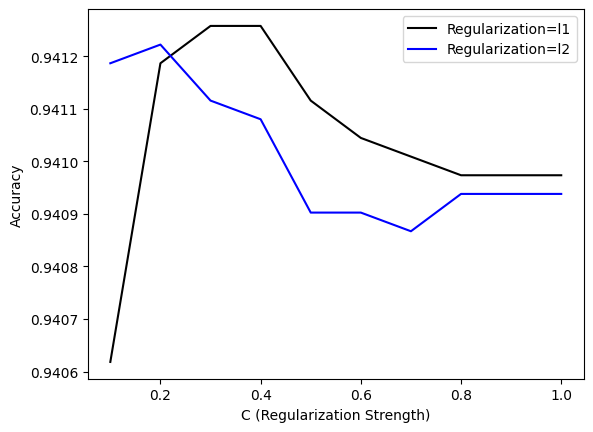

In [80]:
df_scores = pd.DataFrame(scores, columns=['L','C', 'accuracy', 'precision', 'recall', 'auc'])
colors = ['black', 'blue']
l_values = ['l1', 'l2']

for l, col in zip(l_values, colors):
    df_subset = df_scores[df_scores.L == l]
    
    
    plt.plot(df_subset.C, df_subset.accuracy,
             color=col,
             label='Regularization=%s' % l)
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('plots/conditional')
plt.show()

In [81]:
max_accuracy=df_scores['accuracy'].max() # with general  imputation imputed median to numerical columns and mode to categorical columns  (accuracy0.940,  L1, c 0.12 )
df_scores[df_scores['accuracy']==max_accuracy]

L    C  accuracy  precision    recall       auc
2  l1  0.3  0.941258   0.851068  0.824565  0.975129
3  l1  0.4  0.941258   0.851068  0.824565  0.975121

In [82]:
# differentiate between students and working professionals
max_accuracy=df_scores['accuracy'].max() # with conditional imputation if data is missing and not applicable then imputed not applicable or -1  (accuracy0.941,  L2, c=0.09 )
df_scores[df_scores['accuracy']==max_accuracy]


L    C  accuracy  precision    recall       auc
2  l1  0.3  0.941258   0.851068  0.824565  0.975129
3  l1  0.4  0.941258   0.851068  0.824565  0.975121

In [83]:
# differentiate between students and working professionals and combined with original data
max_accuracy=df_scores['accuracy'].max() # with conditional imputation if data is missing and not applicable then imputed not applicable or -1  (accuracy0.940,  L1, c=0.4 )
df_scores[df_scores['accuracy']==max_accuracy]


L    C  accuracy  precision    recall       auc
2  l1  0.3  0.941258   0.851068  0.824565  0.975129
3  l1  0.4  0.941258   0.851068  0.824565  0.975121

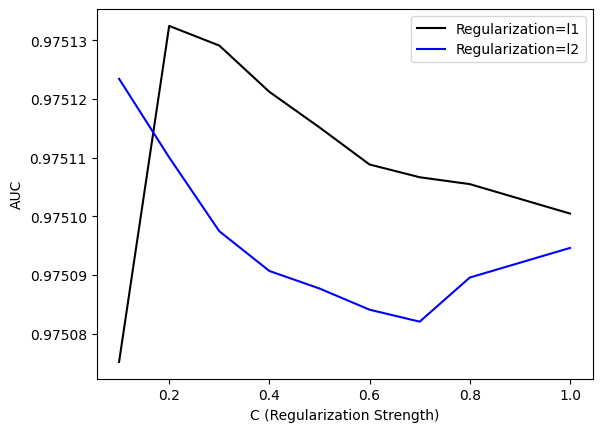

In [84]:
colors = ['black', 'blue']
l_values = ['l1', 'l2']

for l, col in zip(l_values, colors):
    df_subset = df_scores[df_scores.L == l]
    
    
    plt.plot(df_subset.C, df_subset.auc,
             color=col,
             label='Regularization=%s' % l)
   
plt.xlabel('C (Regularization Strength)')
plt.ylabel('AUC')
plt.legend()
plt.savefig('plots/ruc cond')
plt.show()

In [85]:
df_scores.auc.max()

np.float64(0.9751324282198041)

In [86]:
max_auc=df_scores['auc'].max() # imputed 0 to numerical columns and mode to categorical columns   (auc 0.974,  L1, c 0.3 )
df_scores[df_scores['auc']==max_auc]

L    C  accuracy  precision    recall       auc
1  l1  0.2  0.941187    0.85143  0.823598  0.975132

In [87]:
# differentiate between students and working professionals
max_auc=df_scores['auc'].max() # with conditional imputation if data is missing and not applicable then imputed not applicable or -1 (auc 0.975,  L1, c 0.2 )
df_scores[df_scores['auc']==max_auc]

L    C  accuracy  precision    recall       auc
1  l1  0.2  0.941187    0.85143  0.823598  0.975132

In [88]:
# differentiate between students and working professionals when combined with original data
max_auc=df_scores['auc'].max() # with conditional imputation if data is missing and not applicable then imputed not applicable or -1 (auc 0.976,  L1, c 0.2 )
df_scores[df_scores['auc']==max_auc]

L    C  accuracy  precision    recall       auc
1  l1  0.2  0.941187    0.85143  0.823598  0.975132

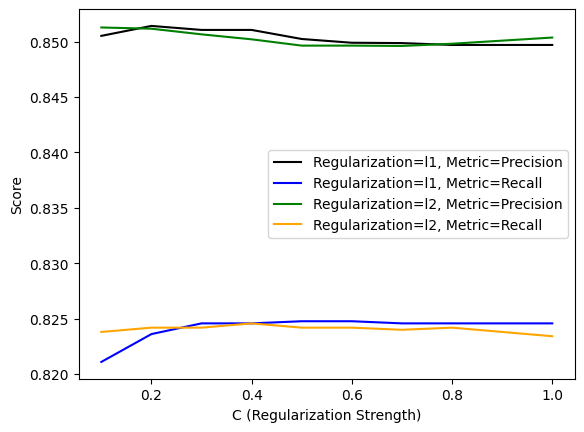

In [89]:
# Define more colors to differentiate each line
colors = ['black', 'blue', 'green', 'orange']
l_values = ['l1', 'l1', 'l2', 'l2']
metrics = ['precision', 'recall']

# Plot each metric with a different color
for i, (l, metric) in enumerate(zip(l_values , metrics * 2)):
    df_subset = df_scores[df_scores.L == l]
    
    # Plot precision and recall with different colors
    plt.plot(df_subset.C, df_subset[metric],
             color=colors[i],
             label=f'Regularization={l}, Metric={metric.capitalize()}')
    
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Score')
plt.legend()
plt.savefig('plots/cond recall')
plt.show()

In [90]:
max_recall=df_scores['recall'].max() # with imputed 0 to numerical columns and mode to categorical columns   (recall 0.822244,  L2, c 0.045, threshold 0.5 )
df_scores[df_scores['recall']==max_recall]

L    C  accuracy  precision    recall       auc
4  l1  0.5  0.941116   0.850249  0.824758  0.975115
5  l1  0.6  0.941045   0.849910  0.824758  0.975109

In [91]:
# conditional imputation between students and professionals
max_recall=df_scores['recall'].max() # with conditional imputation if data is missing and not applicable then imputed not applicable or -1  (recall 0.8247,  L1, c 0.5, threshold 0.5 )
df_scores[df_scores['recall']==max_recall]

L    C  accuracy  precision    recall       auc
4  l1  0.5  0.941116   0.850249  0.824758  0.975115
5  l1  0.6  0.941045   0.849910  0.824758  0.975109

In [92]:
# conditional imputation between students and professionals when combined with original 
max_recall=df_scores['recall'].max() # with conditional imputation if data is missing and not applicable then imputed not applicable or -1  (recall 0.815,  L1, c 0.4, threshold 0.5 )
df_scores[df_scores['recall']==max_recall]

L    C  accuracy  precision    recall       auc
4  l1  0.5  0.941116   0.850249  0.824758  0.975115
5  l1  0.6  0.941045   0.849910  0.824758  0.975109

[[22219   751]
 [  906  4264]]


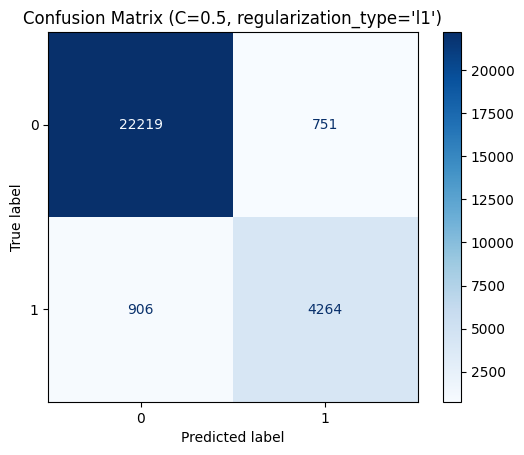

In [93]:
# best logistic regression model for recall
l='l1'
c=0.5
lr=LogisticRegression(penalty=l, solver='liblinear', C=c, max_iter=3000, random_state=42, class_weight=None)
lr.fit(X_train, y_train)
y_pred=lr.predict_proba(X_val)[:,1]
threshold=0.5
cm = confusion_matrix(y_val, y_pred>=threshold)
print(cm)  # Print the raw confusion matrix

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (C={c}, regularization_type='{l}')")
plt.show()

In [94]:
# general imputation FN 919

In [95]:
print(classification_report(y_val, y_pred>=0.5, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22970
           1       0.85      0.82      0.84      5170

    accuracy                           0.94     28140
   macro avg       0.91      0.90      0.90     28140
weighted avg       0.94      0.94      0.94     28140



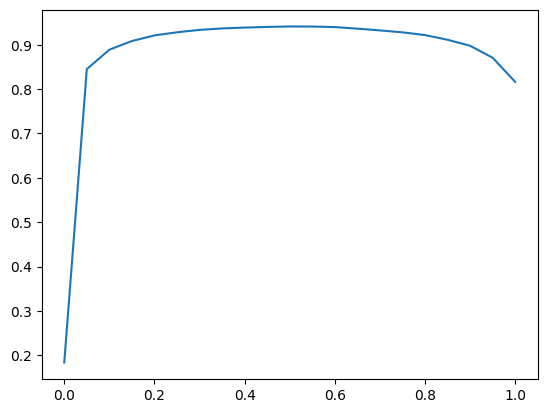

In [96]:
# LR with various thresholds
thresholds = np.linspace(0, 1, 21)

scores_accuracy = []
precision_recall=[]

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    p=precision_score(y_val, y_pred>=t)
    r=recall_score(y_val, y_pred>=t)
    precision_recall.append((t, p,r))
    
    
    #print('%.2f %.3f' % (t, score))
    scores_accuracy.append(score)
plt.plot(thresholds, scores_accuracy); # threshold is best at 0.5 or 0.55

In [97]:
df_precision_recall=pd.DataFrame(precision_recall, columns=['Threshold','Precision', 'Recall'])
#df_precision_recall.Precision

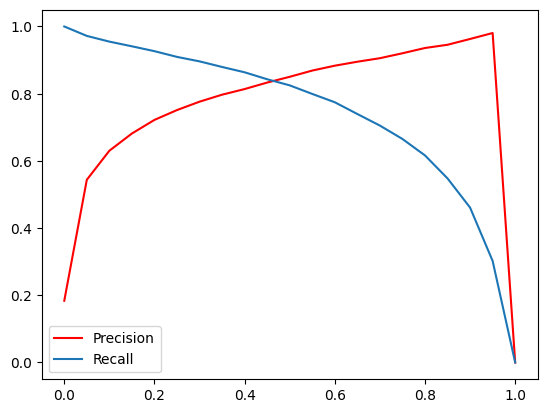

In [98]:
plt.plot(thresholds, df_precision_recall.Precision, label='Precision', color='red')
plt.plot(thresholds, df_precision_recall.Recall, label='Recall')
plt.legend();

In [99]:
df_precision_recall[df_precision_recall.Recall==1]

Threshold  Precision  Recall
0        0.0   0.183724     1.0

### Fine tuning with tree models 

#### Contant parameters: conditional imputation and use only training data

In [100]:
# with conditional imputation differenctiating between students and working professional
df, features =wrangle('data/train.csv', impute='conditional', drop_features=[])
X_train,y_train, X_val, y_val, X_test, y_test=split_data(df, features)

(84420, 19) (28140, 19) (28140, 19)


In [101]:
X_train.shape, X_val.shape

((84420, 276), (28140, 276))

In [102]:
from tqdm import tqdm
scores = []
t0=time.time()
for n in tqdm(range(20,201, 10)):
    rf = RandomForestClassifier(n_estimators=n, random_state=1, class_weight=None)
    rf.fit(X_train, y_train)
    y_pred=rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred>=0.5)
    recall = recall_score(y_val, y_pred>=0.5)
    accuracy=accuracy_score(y_val, y_pred>=0.5)
    
    scores.append((n, auc,recall, accuracy))
t1=time.time()
print(t1-t0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [09:11<00:00, 29.01s/it]

551.2626144886017


In [103]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'AUC', 'Recall', 'Accuracy'])

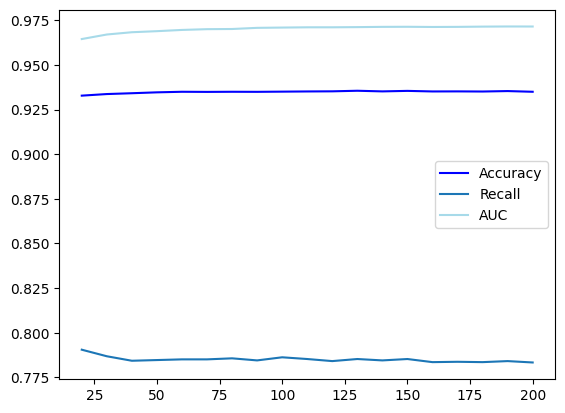

In [104]:
plt.plot(df_scores.n_estimators, df_scores.Accuracy, label='Accuracy', color='Blue') # top auc at estimator 160 to 180
plt.plot(df_scores.n_estimators, df_scores.Recall, label='Recall') # top auc at estimator 160 to 180
plt.plot(df_scores.n_estimators, df_scores.AUC, label='AUC') # top auc at estimator 160 to 180
plt.legend()



Number of estimators are not making much difference

In [105]:
# conditional imputation between students and professionals
max_accuracy=df_scores['Accuracy'].max() # with conditional imputation if data is missing and not applicable then imputed not applicable or -1  (recall 0.8247,  L1, c 0.5, threshold 0.5 )
df_scores[df_scores['Accuracy']==max_accuracy]

n_estimators       AUC  Recall  Accuracy
11           130  0.971172  0.7853  0.935537

In [106]:
# conditional imputation between students and professionals
max_recall=df_scores['Recall'].max() # with conditional imputation if data is missing and not applicable then imputed not applicable or -1  (recall 0.8247,  L1, c 0.5, threshold 0.5 )
df_scores[df_scores['Recall']==max_recall]

n_estimators       AUC    Recall  Accuracy
0            20  0.964492  0.790522    0.9328

In [107]:
scores = []
t0=time.time()
for d in tqdm([25,30,35]):
    for n in range(10,300,20):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred=rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred>=0.5)
        recall = recall_score(y_val, y_pred>=0.5)
        accuracy=accuracy_score(y_val, y_pred>=0.5)
        scores.append((d, n, auc, recall, accuracy))
t1=time.time()
print((t1-t0)/60)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [29:03<00:00, 581.22s/it]

29.06096297899882


In [108]:
columns = ['max_depth', 'n_estimators', 'auc','recall', 'accuracy']
df_scores = pd.DataFrame(scores, columns=columns)

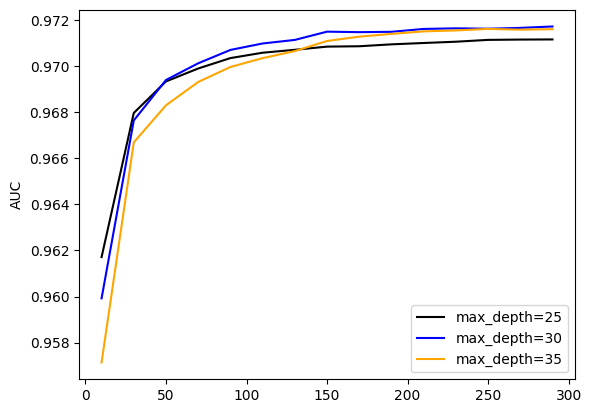

In [109]:
colors =  ['black', 'blue', 'orange']
values = [25, 30, 35]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.max_depth == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='max_depth=%d' % s)
plt.ylabel('AUC')
plt.legend();

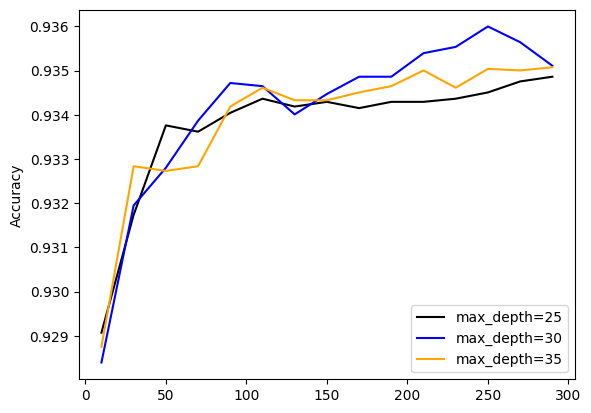

In [110]:
colors = ['black', 'blue', 'orange']
values = [25,30, 35]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.max_depth == s]
    
    plt.plot(df_subset.n_estimators, df_subset.accuracy,
             color=col,
             label='max_depth=%d' % s)
plt.ylabel('Accuracy')
plt.legend();

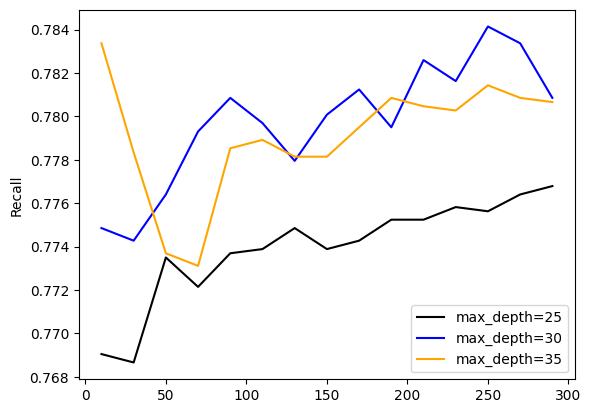

In [111]:
colors = ['black', 'blue', 'orange']
values = [25,30, 35]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.max_depth == s]
    
    plt.plot(df_subset.n_estimators, df_subset.recall,
             color=col,
             label='max_depth=%d' % s)
plt.ylabel('Recall')

plt.legend()
plt.savefig('./plots/randomforest');

max_depth=30 and n_estimators=250

In [112]:
scores = []
t0=time.time()
for d in tqdm([25,30,35]):
    for n in range(300,401,20):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred=rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred>=0.5)
        recall = recall_score(y_val, y_pred>=0.5)
        accuracy=accuracy_score(y_val, y_pred>=0.5)
        scores.append((d, n, auc, recall, accuracy))
t1=time.time()
print((t1-t0)/60)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [27:10<00:00, 543.56s/it]

27.17784844239553


In [113]:
# checking at higher number of trees

In [114]:
columns = ['max_depth', 'n_estimators', 'auc','recall', 'accuracy']
df_scores = pd.DataFrame(scores, columns=columns)

In [115]:
#df_scores

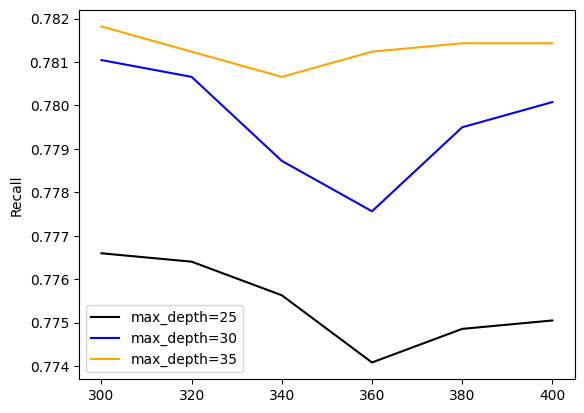

In [116]:
colors = ['black', 'blue', 'orange']
values = [25,30, 35]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.max_depth == s]
    
    plt.plot(df_subset.n_estimators, df_subset.recall,
             color=col,
             label='max_depth=%d' % s)
plt.ylabel('Recall')
plt.legend();

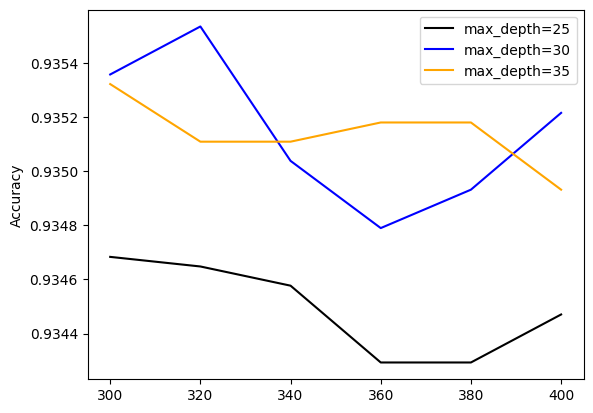

In [117]:
colors = ['black', 'blue', 'orange']
values = [25,30, 35]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.max_depth == s]
    
    plt.plot(df_subset.n_estimators, df_subset.accuracy,
             color=col,
             label='max_depth=%d' % s)
plt.ylabel('Accuracy')
plt.legend();

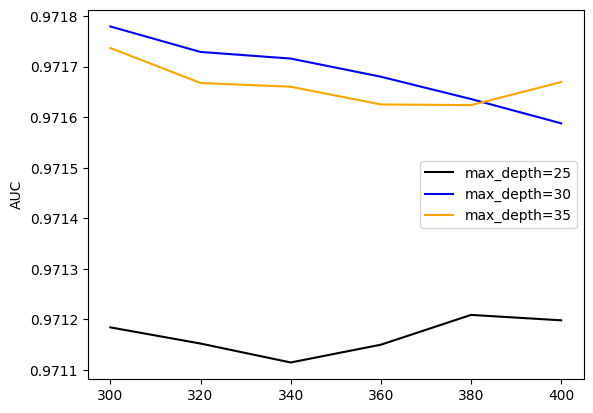

In [118]:
colors =  ['black', 'blue', 'orange']
values = [25, 30, 35]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.max_depth == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='max_depth=%d' % s)
plt.ylabel('AUC')
plt.legend();

In [119]:
max_depth=30

In [120]:
scores = []
t0=time.time()
for s in tqdm([1, 3, 5, 10, 50]):
    for n in range(240,261, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred>=0.5)
        accuracy=accuracy_score(y_val, y_pred>=0.5)
        

        scores.append((s, n, auc,recall, accuracy))
t1=time.time()
print((t1-t0)/60)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [18:38<00:00, 223.67s/it]

18.638977857430778


In [121]:
columns = ['min_sample_leaf', 'n_estimators', 'auc','recall', 'accuracy']
df_scores = pd.DataFrame(scores, columns=columns)

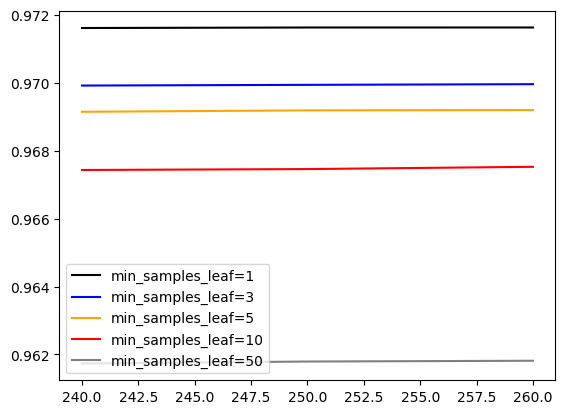

In [122]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_sample_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend();

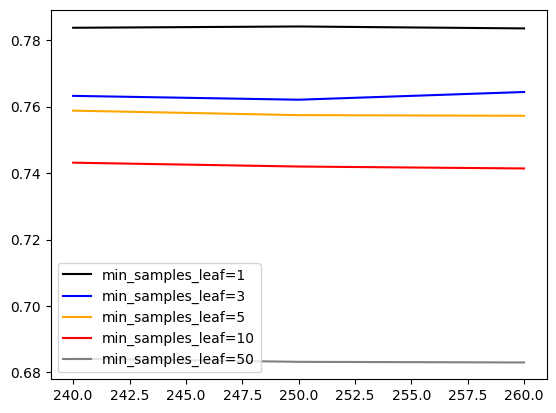

In [123]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_sample_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.recall,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()
plt.savefig('plots/randomforest_highesti');

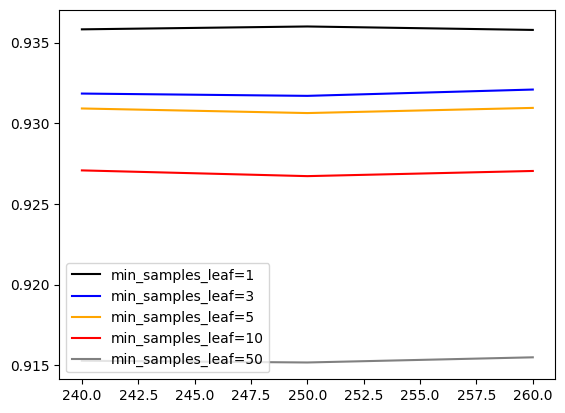

In [124]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_sample_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.accuracy,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend();

In [125]:
# min_sample_leaf=1, estimators=250, depth=30

### XGBoost

In [126]:
# no imputation at all
# df, features=wrangle('data/train.csv', impute=0, drop_features=[])
# df_train, X_train,y_train, X_val, y_val, X_test, y_test=split_data(df, features)

In [127]:
len(features)

17

In [9]:
# with conditional imputation differenctiating between students and working professional
df, features =wrangle('data/train.csv', impute='conditional', drop_features=[])
X_train,y_train, X_val, y_val, X_test, y_test=split_data(df, features)

(84420, 19) (28140, 19) (28140, 19)


In [10]:
len(features), X_train.shape

(17, (84420, 276))

In [11]:
len(features)
features

['age',
 'academic-pressure',
 'work-pressure',
 'cgpa',
 'study-satisfaction',
 'job-satisfaction',
 'work-study-hours',
 'financial-stress',
 'gender',
 'city',
 'working-professional-or-student',
 'profession',
 'sleep-duration',
 'dietary-habits',
 'degree',
 'have-you-ever-had-suicidal-thoughts-?',
 'family-history-of-mental-illness']

In [12]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [13]:
# Define the custom evaluation function for binary recall
def recall_eval(preds, dtrain):
    labels = dtrain.get_label()
    # Convert log odds to probabilities using the sigmoid function
    probabilities = 1 / (1 + np.exp(-preds))
    # Determine binary outcome with threshold 0.5
    predictions = np.where(probabilities >= 0.5, 1, 0)
    recall = recall_score(labels, predictions)
    return 'recall', recall

In [14]:
# base model

In [15]:
xgb_params = {
    'eta': 0.8, 
    'max_depth': 2,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=225        
                 
                 )

In [16]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred) #np.float64(0.9712615647859582) missing values  , np.float64(0.9713882542951912) conditional

np.float64(0.975360873530271)

In [17]:
recall_score(y_val, y_pred>=0.5)  # 0.8212765 gen      0.8203 cond      0.82224 missing  0.818181    drop features

np.float64(0.8334622823984527)

In [208]:
accuracy_score(y_val, y_pred>=0.5) #0.9354655294953802 conditional, 0.9362117981520967 missing   0.9364250177683013 gen

0.9400852878464819

In [209]:
len(dtrain.get_label()), len(dval.get_label())

(84420, 28140)

In [210]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [444]:
%%capture output

xgb_params = {
    'eta': 0.8, 
    'max_depth': 2,
    'min_child_weight': 1,  
    'objective': 'binary:logistic',  
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=1000,
                  evals=watchlist,
                 feval=recall_eval,  # Use the custom evaluation function
                  maximize=True,      # Set to True since we want to maximize recall
                  verbose_eval=5,    # Log every 5th iteration
)

In [445]:
#model.__getattribute__

In [446]:
##dir(model)


In [447]:
y_pred = model.predict(dval)
recall_score(y_val, y_pred>=0.5)

np.float64(0.82321083172147)

In [448]:
s = output.stdout
#s.strip().split('\n')

In [449]:
s.strip().split('\n')[0].split('\t')


['[0]',
 'train-logloss:0.27860',
 'train-recall:0.78707',
 'val-logloss:0.27533',
 'val-recall:0.79207']

In [450]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, tlogloss,train_line, vlogloss, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_recall', 'val_recall']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [451]:
df_score = parse_xgb_output(output)
df_score

num_iter  train_recall  val_recall
0           0       0.78707     0.79207
1           5       0.77128     0.77872
2          10       0.79490     0.80812
3          15       0.80312     0.81586
4          20       0.80736     0.82070
..        ...           ...         ...
196       980       0.84056     0.82456
197       985       0.84115     0.82437
198       990       0.84122     0.82476
199       995       0.84148     0.82437
200       999       0.84141     0.82321

[201 rows x 3 columns]

In [455]:
max=df_score['val_recall'].max()
df_score[df_score['val_recall']==max]   # 0.826 without imputing missing data     0.83308   conditioinal imputation      0.828 with general imputation

num_iter  train_recall  val_recall
45       225        0.8281     0.83308

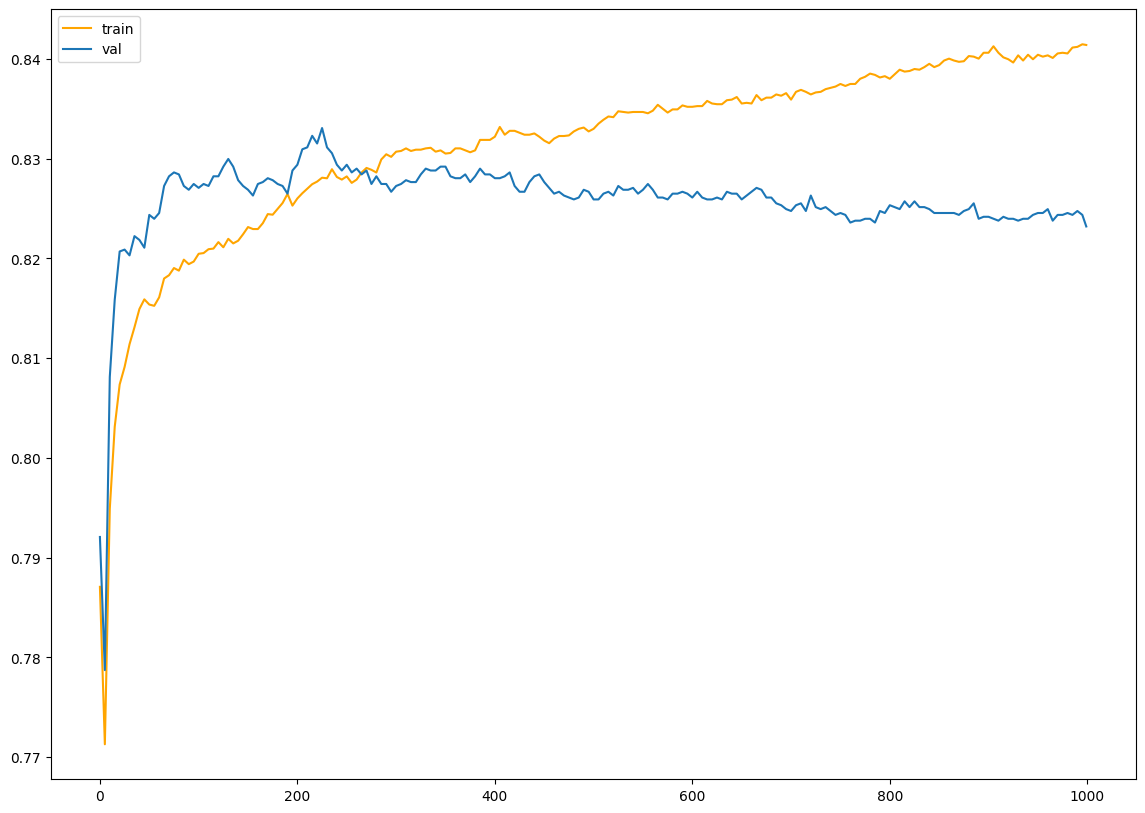

In [453]:
df_score = parse_xgb_output(output)
plt.figure(figsize=(14, 10))
plt.plot(df_score.num_iter, df_score.train_recall, label='train', color='orange')
plt.plot(df_score.num_iter, df_score.val_recall, label='val')
plt.legend();


In [454]:
#df_score

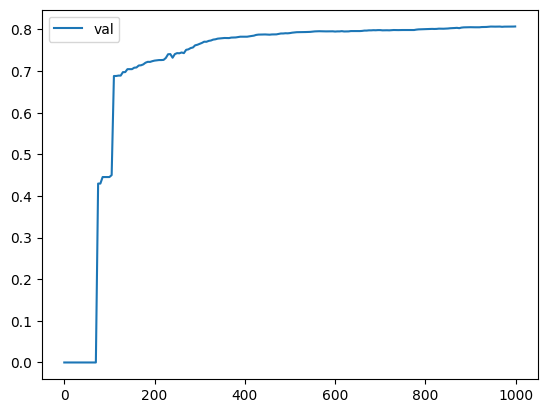

In [202]:
plt.plot(df_score.num_iter, df_score.val_recall, label='val')
plt.legend()



### XGBoost Model parameter tuning

Tuning the following parameters:  

* eta
* max_depth
* min_child_weight

In [250]:
scores = {}

In [276]:
%%capture output

xgb_params = {
    'eta': 0.8, 
    'max_depth': 2,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=1000,
                  evals=watchlist,
                 feval=recall_eval,  # Use the custom evaluation function
                  maximize=True,      # Set to True since we want to maximize recall
                  verbose_eval=5,  # Log every 5th iteration
                 )

In [277]:
s=output.stdout


In [278]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key 

'eta=0.8'

In [279]:
#del scores['eta=0.9']

In [280]:
scores.keys()

dict_keys(['eta=0.2', 'eta=0.1', 'eta=0.3', 'eta=0.4', 'eta=0.6', 'eta=0.8'])

In [281]:
# Red: #FF6347 (Tomato) Green: #008000 (Green) Blue: #4682B4 (Steel Blue) Purple: #6A5ACD (Slate Blue) Orange: #FFA500 (Orange)
#Yellow: #FFD700 (Gold)
#Cyan: #40E0D0 (Turquoise)

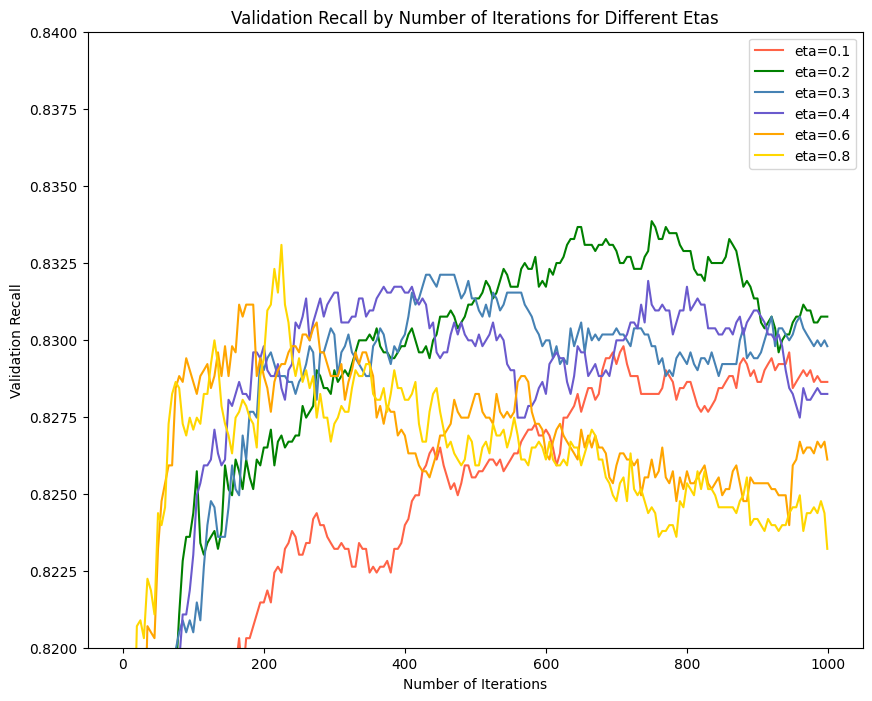

In [289]:
etas = ['eta=0.1','eta=0.2', 'eta=0.3','eta=0.4', 'eta=0.6', 'eta=0.8']
colors = sns.color_palette("viridis", len(etas))  # Assuming seaborn palette
colors=[ '#FF6347', # red tomatoes
    '#008000', # green
    '#4682B4', # steel blue
    '#6A5ACD', # slate blue
    '#FFA500', # orange
    '#FFD700', # gold
   ]
plt.figure(figsize=(10, 8))
for eta, color in zip(etas, colors):
    df_score = scores[eta] 
    plt.plot(df_score.num_iter, df_score.val_recall, label=eta, color=color)

plt.ylim(0.82, 0.84)
plt.xlabel('Number of Iterations')
plt.ylabel('Validation Recall')
plt.title('Validation Recall by Number of Iterations for Different Etas')
plt.legend()
plt.savefig('plots/xgb_eta')
plt.show()

In [303]:
metrics=scores['eta=0.8']
max=metrics['val_recall'].max()
metrics[metrics['val_recall']==max]   # 0.833  0.8 at 225   or 0.8338 0.2 at 750

num_iter  train_recall  val_recall
45       225        0.8281     0.83308

In [411]:
eta=0.8
scores={}

In [426]:
%%capture output

xgb_params = {
    'eta': 0.8, 
    'max_depth':5,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=300,
                  evals=watchlist,
                 feval=recall_eval,  # Use the custom evaluation function
                  maximize=True,      # Set to True since we want to maximize recall
                  verbose_eval=5,  # Log every 5th iteration
                 )

In [427]:
s=output.stdout

In [428]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=5'

In [429]:
#del scores['max_depth=1']

In [430]:
scores.keys()

dict_keys(['max_depth=3', 'max_depth=2', 'max_depth=4', 'max_depth=5'])

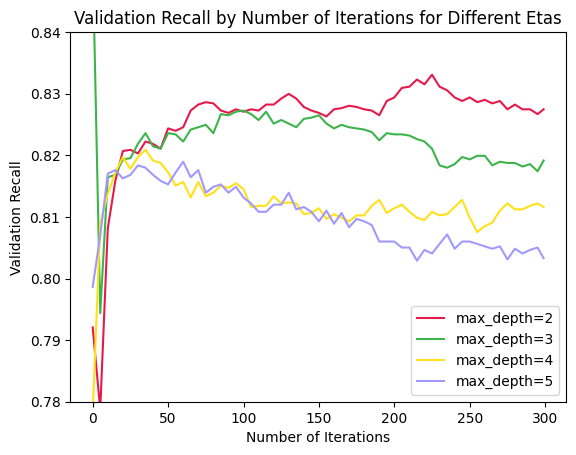

In [434]:
max_depth = ['max_depth=2', 'max_depth=3','max_depth=4', 'max_depth=5']
colors=[ '#e6194B', # red
    '#3cb44b', # green
    '#ffe119', # yellow
    '#A299FF', # blue
    '#f58231', # orange
    '#911eb4', # purple
    '#46f0f0', # cyan
   ]

for eta, color in zip(max_depth, colors):
    df_score = scores[eta] 
    plt.plot(df_score.num_iter, df_score.val_recall, label=eta, color=color)

plt.ylim(0.78, 0.84)
plt.xlabel('Number of Iterations')
plt.ylabel('Validation Recall')
plt.title('Validation Recall by Number of Iterations for Different Etas')
plt.legend()
plt.savefig('plots/xgboost depth')
plt.show()

In [432]:
metrics=scores['max_depth=2']
max=metrics['val_recall'].max()
metrics[metrics['val_recall']==max]   # 0.83308

num_iter  train_recall  val_recall
45       225        0.8281     0.83308

In [342]:
#max_depth=2, eta 0.8

In [346]:
scores={}

In [437]:
%%capture output

xgb_params = {
    'eta': 0.8, 
    'max_depth':2,
    'min_child_weight':1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=300,
                  evals=watchlist,
                 feval=recall_eval,  # Use the custom evaluation function
                  maximize=True,      # Set to True since we want to maximize recall
                  verbose_eval=5,  # Log every 5th iteration
                 )

In [438]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=1'

In [383]:
#del scores['min_child_weight=3']

In [384]:
scores.keys()

dict_keys(['min_child_weight=1', 'min_child_weight=2', 'min_child_weight=3', 'min_child_weight=4', 'min_child_weight=5', 'min_child_weight=6'])

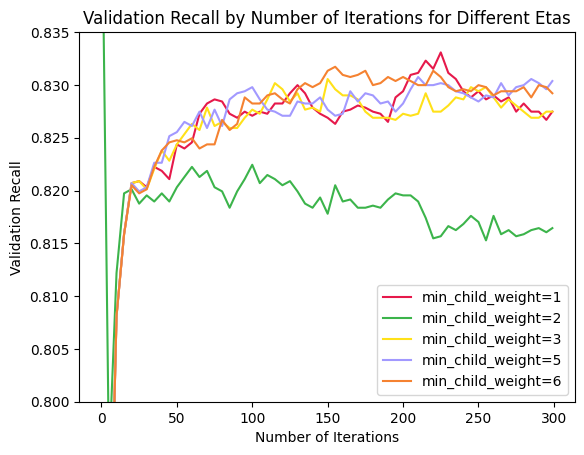

In [388]:
min_child_weight = ['min_child_weight=1', 'min_child_weight=2', 'min_child_weight=3', 'min_child_weight=5', 'min_child_weight=6']
colors=[ '#e6194B', # red
    '#3cb44b', # green
    '#ffe119', # yellow
    '#A299FF', # blue
    '#f58231', # orange
    '#911eb4', # purple
    '#46f0f0', # cyan
   ]

for eta, color in zip(min_child_weight, colors):
    df_score = scores[eta] 
    plt.plot(df_score.num_iter, df_score.val_recall, label=eta, color=color)

plt.ylim(0.80, 0.835)
plt.xlabel('Number of Iterations')
plt.ylabel('Validation Recall')
plt.title('Validation Recall by Number of Iterations for Different Etas')
plt.legend()
plt.savefig('./plots/xgboost_mchildweight')
plt.show()

In [400]:
metrics=scores['min_child_weight=1']
max=metrics['val_recall'].max()
metrics[metrics['val_recall']==max]   # 0.83308

num_iter  train_recall  val_recall
45       225        0.8281     0.83308

In [390]:
# best model #max_depth=2, eta 0.8 min_child_weight=1

In [20]:
%%capture output

xgb_params = {
    'eta': 0.8, 
    'max_depth':2,
    'min_child_weight': 1, 
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=225,
                 
                 )

In [21]:
preds=model.predict(dval)
recall_score(y_val, preds>=0.5)

np.float64(0.8334622823984527)

### Selecting the final model
Choosing between xgboost, random forest and logistic regression  
Training the final model  
Saving the model

In [23]:
# best logistic regression model for recall
lr=LogisticRegression(penalty='l1', solver='liblinear', C=0.5, max_iter=3000, random_state=42, class_weight=None)
lr.fit(X_train, y_train)
y_pred=lr.predict_proba(X_val)[:,1]
recall_score(y_val, y_pred>=0.5)

np.float64(0.8247582205029014)

In [56]:
# best random forest model
rf = RandomForestClassifier(n_estimators=250,
                            max_depth=30,
                            min_samples_leaf=1,
                            random_state=1)
rf.fit(X_train, y_train)
y_pred=rf.predict_proba(X_val)[:,1]
recall_score(y_val, y_pred>=0.5)

np.float64(0.7841392649903288)

### Model Interpretation

In [ ]:
#rf.feature_importances_

In [ ]:
importances = list(zip(dv.feature_names_, rf.feature_importances_))

df_importance = pd.DataFrame(importances, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False)
df_importance

In [ ]:
df_importance = df_importance[df_importance.gain > 0.01]

In [ ]:
num = len(df_importance)
plt.barh(range(num), df_importance.gain[::-1])
plt.yticks(range(num), df_importance.feature[::-1])

plt.show()

In [31]:
# best xgboost model
xgb_params = {
    'eta': 0.8, 
    'max_depth': 2,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=225,
                 
                 feval=recall_eval,  # Use the custom evaluation function
                  maximize=True,      # Set to True since we want to maximize recall
                  verbose_eval=5,  # Log every 5th iteration
                 )

In [32]:
y_pred = model.predict(dval)
recall_score(y_val, y_pred>=0.5) 

np.float64(0.8334622823984527)

In [33]:
scores = model.get_score(importance_type='gain')
scores = sorted(scores.items(), key=lambda x: x[1])
#list(reversed(scores))

In [34]:
scores = model.get_score(importance_type='weight')
scores = sorted(scores.items(), key=lambda x: x[1])
#list(reversed(scores))

In [35]:
#scores

In [36]:
names = [n for (n, s) in scores[-15:-1]]
scores = [s for (n, s) in scores[-15:-1]]

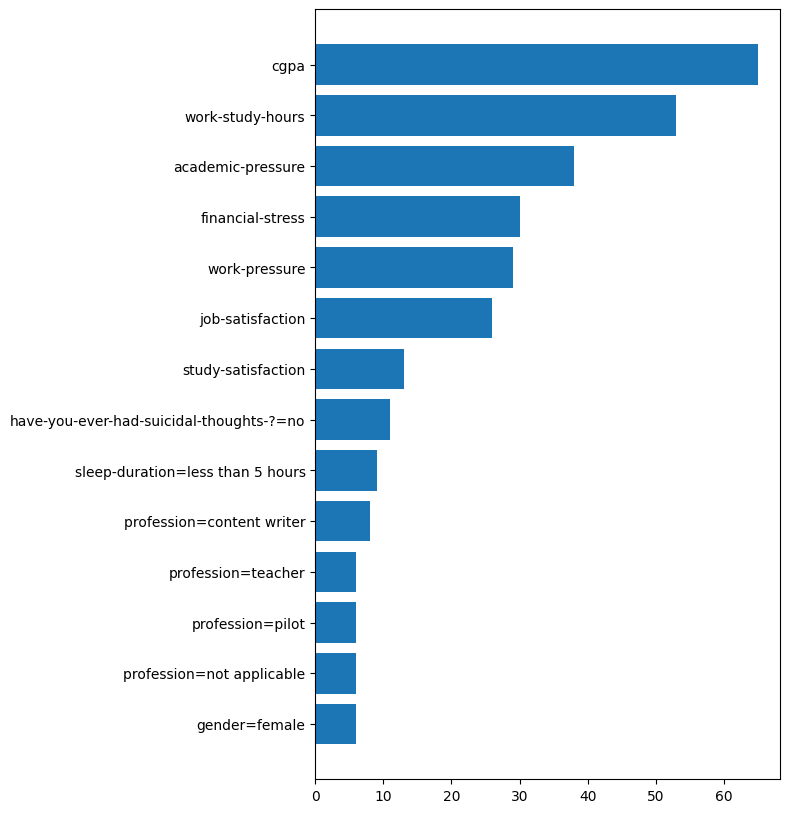

In [37]:
plt.figure(figsize=(6, 10))

plt.barh(np.arange(len(scores)), scores)
plt.yticks(np.arange(len(names)), names)

plt.show()

In [38]:
df,features=wrangle('data/train.csv', impute='conditional')

In [39]:
# Train the final model with training and validation data
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train_full = df_train_full.reset_index(drop=True)
y_train_full = df_train_full.depression.values

In [40]:
del df_train_full['depression']

In [41]:
dicts_train_full = df_train_full[features].to_dict(orient='records')

dv = DictVectorizer(sparse=True)
X_train_full = dv.fit_transform(dicts_train_full)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [42]:
dv

DictVectorizer()

In [43]:
X_train_full.shape

(112560, 313)

In [44]:
#dv.get_feature_names_out()

In [45]:
feature_names = list(dv.get_feature_names_out())
dfulltrain = xgb.DMatrix(X_train_full, label=y_train_full,
                    feature_names=feature_names)

dtest = xgb.DMatrix(X_test, feature_names=feature_names)

In [46]:
xgb_params = {
    'eta': 0.8, 
    'max_depth': 2,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=225)

In [47]:
y_pred = model.predict(dtest)

In [48]:
recall_score(y_test, y_pred>=0.5) 

np.float64(0.819060773480663)

In [49]:
import pickle

# Saving the model with pickle
with open('./depression_predictor/best_xgboost.bin', 'wb') as file:
    pickle.dump((dv,model), file)



DictVectorizer()

## Submit to Kaggle competition

In [53]:
# Loading the model with pickle
with open('./depression_predictor/best_xgboost.bin', 'rb') as file:
    dv,loaded_model = pickle.load(file)



In [55]:
dv

DictVectorizer()

In [ ]:
rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)

In [ ]:
df_test, features= wrangle('test.csv', impute='conditional')
df_test.shape, len(features)

In [ ]:
# with conditional imputation differenctiating between students and working professional
#df, features =wrangle('data/train.csv', impute='conditonal', drop_features=[])

In [ ]:
#combining with original data
df1, features =wrangle('data/train.csv', impute='conditional', drop_features=[])
df2, features =wrangle('data/final_depression_dataset_1.csv', impute='conditional', drop_features=[])
df2['depression']=df2['depression'].map( {'Yes':1 ,'No':0}) 
df=pd.concat([df1, df2], ignore_index=True)

In [ ]:
lr=LogisticRegression(penalty='l2',  solver='liblinear', C=0.09, max_iter=3000, random_state=42)
lr.fit(X_train, y_train)

In [ ]:
test_submit_dict=df_test[features].to_dict(orient='records')
X_test=dv.transform(test_submit_dict)
X_test

In [ ]:
features = list(dv.get_feature_names_out())
dtest = xgb.DMatrix(X_test, feature_names=features)

In [ ]:
# Make predictions using the loaded model
y_pred_proba = loaded_model.predict(dtest, iteration_range=(0, 70))
y_pred=(y_pred_proba>=0.5)

In [ ]:
y_pred=y_pred.astype(int)

In [ ]:
y_pred

In [ ]:
# Create a DataFrame to hold the submission results
output = pd.DataFrame({'id': df_test['id'],
                       'class': y_pred})

# Save the output DataFrame to a CSV file
output.to_csv('submission.csv', index=False)

output.head()

In [ ]:
# got 94.1 when I imputed conditionally with lR and combining data did not improve the result